# Scenario notes

Using the NOAA SLR scenarios we can do a couple different iterations 

NOAA SLR Scenarios  https://coast.noaa.gov/slr/#/layer/sce/0/-17821114.951125123/1934329.2023005919/3/satellite/60/0.8/2090/interHigh/midAccretion

Year 2040
Intermediate Low : 0.72ft 0.22m 
Intermediate : 1.02ft
Intermediate High : 1.38ft
High : 1.71ft
Extreme : 1.94ft  0.59m

                    
Year 2090               
Intermediate Low : 1.84ft  0.56m
Intermediate : 3.44ft
Intermediate High : 5.15ft
High : 6.92ft
Extreme : 8.33ft  2.54m


Three scenarios to model, and present ranges from:  

2040
Low : 0.72ft 0.22m  to  Extreme : 1.94ft  0.59

Year 2090 No change in climate
Low : 1.84ft  0.56m  to Extreme : 8.33ft  2.54m

Year 2090 RCP4.5  climate  
Low : 1.84ft  0.56m  to Extreme : 8.33ft  2.54m


Thus need 3 (6?) model runs with the following levels: 

2 ft = 2040 extreme and 2080 Low = 0.6 m
5 ft = 2090 Intermediate High    = 1.57 m
8 ft = 2090 Extreame             = 2.54 m

Then add 2090 recharge?




Notes and limitations: 
- While the subsidence induced SLR is likely not factored into these predictions the amount of total subsidence as projected by Han is in the range of 30-40 cm, with 



In [1]:
from IPython.display import display, HTML
display(HTML(data="""
<style>
    div#notebook-container { width: 95%;} div#menubar-container { width: 85%; } div#maintoolbar-container { width: 99%; } </style> """))
 
# %matplotlib inline

import os
import sys
import platform
import math
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import flopy
import flopy.utils.binaryfile as bf
from flopy.export.shapefile_utils import shp2recarray
from rasterio import Affine
from flopy.utils.reference import SpatialReference
from flopy.utils.postprocessing import get_transmissivities, get_water_table, get_gradients

import shapefile    # not used directly here but for some reason flopy needs this to do shapefile stuff and BTW its not import pyshp as you would think its import shapefile, dumb...
import pandas as pd
import fiona
from rasterio.features import rasterize
import rasterio
import rasterio.mask
import geopandas
from osgeo import gdal

#import simplekml
import ogr
from shapely.wkb import loads

from scipy.interpolate import interp2d
import scipy.optimize as opt


print(sys.version)
print('numpy version: {}'.format(np.__version__))
print('matplotlib version: {}'.format(mpl.__version__))
print('flopy version: {}'.format(flopy.__version__))

#Set name of MODFLOW exe
#  assumes executable is in users path statement
exe_name = 'mf2005'
if platform.system() == 'Windows':
    exe_name = 'mf2005.exe'

workspace = os.path.join("..", "..", 'RISA_yr6_GIT_ignored_files', 'Flo_py_wrkspace5p2')
#make sure workspace directory exists
if not os.path.exists(workspace):
    os.makedirs(workspace)
    
tempspace = os.path.join(workspace, "temp")
#make sure workspace directory exists
if not os.path.exists(tempspace):
    os.makedirs(tempspace)
    
figurespace = os.path.join(workspace, "Figures")
if not os.path.exists(figurespace):
    os.makedirs(figurespace)
    
WGS84UTM2S_string = 'PROJCS["WGS_1984_UTM_Zone_2S",GEOGCS["GCS_WGS_1984",DATUM["D_WGS_1984",SPHEROID["WGS_1984",6378137,298.257223563]],PRIMEM["Greenwich",0],UNIT["Degree",0.017453292519943295]],PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",0],PARAMETER["central_meridian",-171],PARAMETER["scale_factor",0.9996],PARAMETER["false_easting",500000],PARAMETER["false_northing",10000000],UNIT["Meter",1]]'
pd.set_option('display.max_rows', 75)

# define the spatial reference object 
model_epsg = 32702   # epsg code specifying coordinate reference system: in this case, UTM zone 2S, WGS 84, A proj4 string has also been fetched from <spatialreference.org> using the supplied epsg code.

# in line plotting and saving options. Change these to plot or not to plot inline
Plotnsave_plot = True
Plotnsave_save = True

flopy is installed in C:\Users\cshuler\AppData\Local\Continuum\anaconda3\envs\ASPA_Framework\lib\site-packages\flopy
3.8.2 | packaged by conda-forge | (default, Feb 28 2020, 16:38:51) [MSC v.1916 64 bit (AMD64)]
numpy version: 1.18.1
matplotlib version: 3.1.3
flopy version: 3.3.0


# Model geometry notes


model boundaries square at 
X	Y
- 530200	8425825
- 537700	8425825
- 537700	8418325
- 530200	8418325

with length of 7500 m on both sides


next steps 
- try and just follow existing github model notebook 

Shapefile Boundaries: (530200.0, 8418325.0, 537700.0000000009, 8425825.000000002)
wrote ..\..\RISA_yr6_GIT_ignored_files\Flo_py_wrkspace5p2\Model_polyarea.shp
wrote ..\..\RISA_yr6_GIT_ignored_files\Flo_py_wrkspace5p2\Model_grid.shp


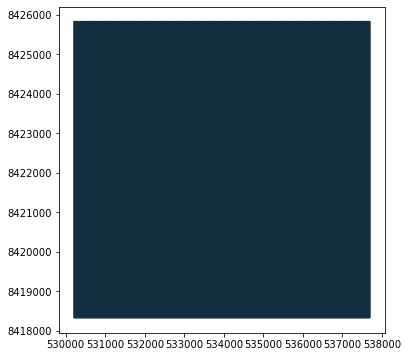

In [2]:
''' Define the number of layers, rows and columns.'''
# Note works at 100, 150, 300, 750, 1500
# Does not work at 600

ncol = 1500
nrow = 1500
nlay = 1

# model run times
nper = 1                     # Number of model stress periods (the default is 1)
perlen = [3650]              # An array of the stress period lengths in days separated by commas
nstp = [1]      # Number of time steps in each stress period (default is 1).
save_head = [3650]
steady = True
rotation = 0                             # rotation (positive counterclockwise)

# this cell inports the boundary shapefile to make the model around
ra = shp2recarray(os.path.join("..", "Data/Raw/GIS", 'model_square.shp'))
# these are the bondaries of the shapefile
shp_xmin = round(ra.geometry[0].bounds[0],1)
shp_ymin = round(ra.geometry[0].bounds[1],1)
shp_xmax = round(ra.geometry[0].bounds[2],1)
shp_ymax = round(ra.geometry[0].bounds[3],1)
print("Shapefile Boundaries: {}".format(ra.geometry[0].bounds))  

xll = int(shp_xmin)  # Lower left corner of model grid  
yll = int(shp_ymin)   # Lower left corner of model grid 


# grid spacing as a percentage of model x domain (in model units) note 10% buffer around boundary
delr = abs(int((shp_xmax-shp_xmin)/ncol))   # the width of each cell
delc = abs(int((shp_ymax-shp_ymin)/nrow))   # the height of eech cell
delr_4_sr  = np.ones(ncol, dtype=float) * delr    # This just puts the above into an array for the sr object 
delc_4_sr = np.ones(nrow, dtype=float) * delc   

# create the model boundary area polygon
sr = SpatialReference(delr=[delr_4_sr.sum()], delc=[delc_4_sr.sum()], xll=xll, yll=yll, rotation=rotation, proj4_str=WGS84UTM2S_string, lenuni=2) #  # model length units (1 for feet, 2 for meters (default)) (also calculeted uper left corner of model) 
sr.write_shapefile(os.path.join(workspace, 'Model_polyarea.shp'))          # write a shapefile of the model area for later use
prj = open(os.path.join(workspace, 'Model_polyarea.prj'), "w"); prj.write(WGS84UTM2S_string) ; prj.close()     # write the .prj file manually
#print("corners are at {}".format(sr.get_extent()))

# create the model boundary grid polygon   (NOTE THIS MUST OVERWRITE THe PREVIOUS sr. definition!)
sr = SpatialReference(delr=delr_4_sr, delc=delc_4_sr, xll=xll, yll=yll, rotation=rotation, proj4_str= '+proj=longlat +ellps=WGS84 +datum=WGS84 +no_defs' , lenuni=2) #  # model length units (1 for feet, 2 for meters (default)) (also calculeted uper left corner of model) 
sr.write_shapefile(os.path.join(workspace, 'Model_grid.shp'))          # write a shapefile of the model grid for later use
prj = open(os.path.join(workspace, 'Model_grid.prj'), "w"); prj.write(WGS84UTM2S_string) ; prj.close()   # write the .prj file manually

# output control parameters
spd = {(0, 0): ['print head', 'print budget', 'save head', 'save budget']}    

if Plotnsave_plot: 
    fig, ax = plt.subplots(figsize=(12,6))
    Tutuila = geopandas.read_file(os.path.join("..", "Data/Raw/GIS", 'model_square.shp'))
    Grid = geopandas.read_file(os.path.join(workspace, 'Model_grid.shp'))
    Grid.plot(ax=ax, facecolor="white", edgecolor="Black", linewidth=.2)
    Tutuila.plot(ax=ax, linewidth=2, alpha = .3)

### Assign Layer elevations from a DEM

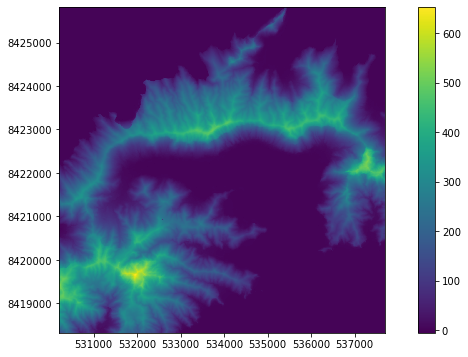

In [3]:
#Set model top to DEM
# Needed to clip the raster to appropriate dimensions, () https://rasterio.readthedocs.io/en/stable/topics/masking-by-shapefile.html)
Raster_2_Clip = os.path.join("..",  'Data/Raw/GIS/3m_DEM', '3m_dem_cp.tif')
Clipped_raster = os.path.join(workspace, "DEM_10m_clip.asc")

with fiona.open(os.path.join(workspace, 'Model_polyarea.shp'), "r") as shapefile:
    features = [feature["geometry"] for feature in shapefile]
    
with rasterio.open(Raster_2_Clip) as src:
    out_image, out_transform = rasterio.mask.mask(src, features,
                                                        crop=True)
out_meta = src.meta.copy()

out_meta.update({"driver": "AAIGrid",
                 "height": out_image.shape[1],
                 "width": out_image.shape[2],
                 "transform": out_transform})
with rasterio.open(Clipped_raster, "w", **out_meta) as dest:
    dest.write(out_image)
    
# Now disect the clipped .asc into a 
Top_raw = np.loadtxt(Clipped_raster, skiprows=7)   # the 7th row was a no data row for some reason not sure why, if another DEM is used might need to skiprows back to 6

y = np.linspace(0, np.shape(Top_raw)[0]-1, np.shape(Top_raw)[0])   
x = np.linspace(0, np.shape(Top_raw)[1]-1, np.shape(Top_raw)[1])

y2 = np.linspace(0, np.shape(y)[0], nrow)   # this defines the number of cells to resample to on the y direction, first number is the original height of the SWB2 recharge map, second number is going to be new height in # of cells
x2 = np.linspace(0, np.shape(x)[0], ncol)   # this defines the number of cells to resample to on the x direction, first number is the original width of the SWB2 recharge map, second number is going to be new width in # of cells

f = interp2d(x, y, Top_raw, kind='cubic')
top = f(x2, y2)

botm = -500    # this will clearly need to change to accomadate the Tutuila bathymetry
top = np.where(top <= botm, botm+10, top) # force top elevations to always be higher than bottom elevations

if Plotnsave_plot: 
    fig, ax = plt.subplots(figsize = (12,6))
    qm = sr.plot_array(top, ax=ax)
    ax.set_aspect(1); plt.colorbar(qm)

Starting heads will be tricky.  Easiest might be to assign starting heads of 0.01 in ocean, then heads of 10 m less than top elevation in land surface areas, if optimization yields different starting heads then can modify. could also use the ending heads from the regional model. 


overall, I bound needs to be 

### starting heads

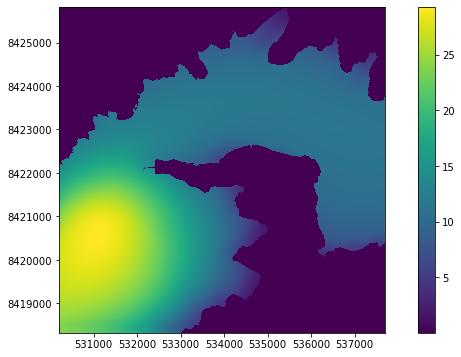

In [4]:
## First import regional heads from the regional model

Raster_2_Clip = os.path.join("..",  'Data/Raw/From_regional', 'PyPCGA_model_Heads_Clip.tif')
Clipped_raster = os.path.join(workspace, "PyPCGA_model_Heads_Clip.asc")

with fiona.open(os.path.join(workspace, 'Model_polyarea.shp'), "r") as shapefile:
    features = [feature["geometry"] for feature in shapefile]
    
with rasterio.open(Raster_2_Clip) as src:
    out_image, out_transform = rasterio.mask.mask(src, features,
                                                        crop=True)
out_meta = src.meta.copy()

out_meta.update({"driver": "AAIGrid",
                 "height": out_image.shape[1],
                 "width": out_image.shape[2],
                 "transform": out_transform})
with rasterio.open(Clipped_raster, "w", **out_meta) as dest:
    dest.write(out_image)
    
# Now disect the clipped .asc into a 
Top_raw = np.loadtxt(Clipped_raster, skiprows=7)   # the 7th row was a no data row for some reason not sure why, if another DEM is used might need to skiprows back to 6

y = np.linspace(0, np.shape(Top_raw)[0]-1, np.shape(Top_raw)[0])   
x = np.linspace(0, np.shape(Top_raw)[1]-1, np.shape(Top_raw)[1])

y2 = np.linspace(0, np.shape(y)[0], nrow)   # this defines the number of cells to resample to on the y direction, first number is the original height of the SWB2 recharge map, second number is going to be new height in # of cells
x2 = np.linspace(0, np.shape(x)[0], ncol)   # this defines the number of cells to resample to on the x direction, first number is the original width of the SWB2 recharge map, second number is going to be new width in # of cells

f = interp2d(x, y, Top_raw, kind='cubic')
regional_Heads = f(x2, y2)

#botm = -500    # this will clearly need to change to accomadate the Tutuila bathymetry
#top = np.where(top <= botm, botm+10, top) # force top elevations to always be higher than bottom elevations


# then explicitly say that the ocean area has a specified head, since the regional heads are fuzzy

with fiona.open(os.path.join("..",  'Data/Raw/GIS/ibounds/For_heads', 'Land_Ocean.shp')) as src:   #    read in Tutuila shapefile
    records = [r for r in src] 
geoms = [r['geometry'] for r in records]       # shapefile shape
attr = [r['properties'] for r in records]      # shapefile attributes
geoms = [(g, attr[i]['OceanCell'])for i, g in enumerate(geoms) ]              # select the attribute to map onto the raster grid
# affine: work with the geometry to change from raster to grid reference frame 
trans = Affine(delr, rotation, sr.xul, sr.rotation, -delc, sr.yul)
mask = rasterize(geoms, out_shape=(nrow, ncol), transform=trans) # the actual rasterization 

masked_heads = abs(regional_Heads)*mask                        # set ocean cells to a negative number through multoplication with -1
Ocean_starting_head = 0.01   # in meters 
start_heads = np.where(masked_heads < 0, Ocean_starting_head, masked_heads) # Set ocean cells (defined as any negative values in the array) to Ocean_starting_head value

if Plotnsave_plot: 
    fig, ax = plt.subplots(figsize = (12,6))
    qm = sr.plot_array(start_heads, ax=ax)
    ax.set_aspect(1); plt.colorbar(qm)

### make new ibound and specified head 
- Negative ibound (-1) is constant head
- Ibound of (0) is inactive
- Any positive Ibound (1) is variable head (active) 

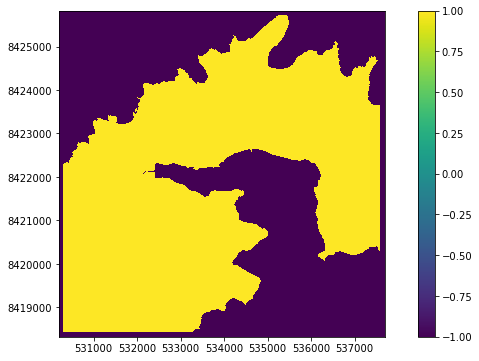

In [5]:
#### Use a Tutuila polygon to define the model active area as the island and the ghb cells as the offshore cells

with fiona.open(os.path.join("..", 'Data/Raw/GIS/ibounds', 'ibound_specHd_w_100m_buff.shp')) as src:   #    read in Tutuila shapefile
    records = [r for r in src] 
geoms = [r['geometry'] for r in records]       # shapefile shape
attr = [r['properties'] for r in records]      # shapefile attributes
geoms = [(g, attr[i]['ibound'])for i, g in enumerate(geoms) ]              # select the attribute to map onto the raster grid
# affine: work with the geometry to change from raster to grid reference frame 
trans = Affine(delr, rotation, sr.xul, sr.rotation, -delc, sr.yul)
ibound = rasterize(geoms, out_shape=(nrow, ncol), transform=trans) # the actual rasterization 

if Plotnsave_plot: 
    fig, ax = plt.subplots(figsize = (12,6))
    qm = sr.plot_array(ibound, ax=ax)
    ax.set_aspect(1); plt.colorbar(qm)

### Create Drains 
this takes a minute

<ipython-input-6-986df227621b>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  intersections['RastVal'][intersections['RastVal'] > 100] = intersections['RastVal'] - 50
<ipython-input-6-986df227621b>:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  intersections['RastVal'][intersections['RastVal'] > 10] = intersections['RastVal'] - 1
<ipython-input-6-986df227621b>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  intersections['RastV

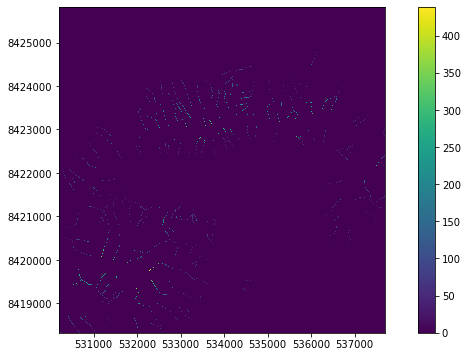

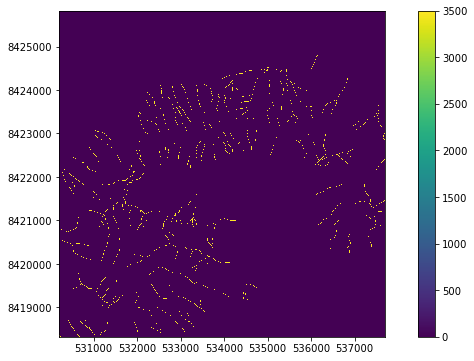

In [6]:
conductance_value = 3500

# Intersect streams with the grid cells using GEOPANDAS!! :)
lines = geopandas.GeoDataFrame.from_file(os.path.join("..", "Data/Raw/GIS", "Streams", 'Streams_All_WGS2S.shp'))
poly = geopandas.GeoDataFrame.from_file(os.path.join(workspace, 'Model_grid.shp'))
# Do the spatial intersect to just pull out cells that hit streams
intersections= geopandas.sjoin(poly, lines, how="inner", op='intersects')
intersections["x"] = intersections.centroid.x # pull out the x coordiate
intersections["y"] = intersections.centroid.y # pull out the y coordiate
intersections["Cond"] = conductance_value
# Write the geopandas dataframe to a esri shapefile 
intersections.to_file(driver = 'ESRI Shapefile', filename = os.path.join(workspace, 'Stream_grid_intersects.shp'))          # write a shapefile of the model grid for later use
prj = open(os.path.join(workspace, 'Stream_grid_intersects.prj'), "w"); prj.write(WGS84UTM2S_string) ; prj.close()   # write the .prj file manually

# Extract elevation values to the points from the DEM
Clipped_DEM_raster = os.path.join(workspace, "DEM_10m_clip.asc")   # from the DEM used above
src = rasterio.open(Clipped_DEM_raster) 
coords = [(x,y) for x, y in zip(intersections["x"], intersections["y"])]  # This woll pull the cooordinate values out of the centrods of the intersections frame above
intersections['RastVal'] = [x[0] for x in src.sample(coords)]


# Modify elevations a bit
intersections['RastVal'][intersections['RastVal'] > 100] = intersections['RastVal'] - 50
intersections['RastVal'][intersections['RastVal'] > 10] = intersections['RastVal'] - 1
intersections['RastVal'][intersections['RastVal'] > 3] = intersections['RastVal'] - 1
intersections['RastVal'][intersections['RastVal'] > 2] = intersections['RastVal'] - 1
intersections['RastVal'][intersections['RastVal'] > 1] = intersections['RastVal'] - .5

# Reset any values that ended up as 0s
intersections['RastVal'][intersections['RastVal'] == 0] = 0.1  #(will make pink box)

# Write to shapefile 
intersections.to_file(driver = 'ESRI Shapefile', filename = os.path.join(workspace, 'Stream_grid_intersects_Elevations.shp'))          # write a shapefile of the model grid for later use
prj = open(os.path.join(workspace, 'Stream_grid_intersects_Elevations.prj'), "w"); prj.write(WGS84UTM2S_string) ; prj.close()   # write the .prj file manually


# Create a model square array with the point values elevation as the elevation 
with fiona.open(os.path.join(workspace, 'Stream_grid_intersects_Elevations.shp')) as src:   #    read in Tutuila shapefile
    records = [r for r in src] 
geoms = [r['geometry'] for r in records]       # shapefile shape
attr = [r['properties'] for r in records]      # shapefile attributes
geoms = [(g, attr[i]['RastVal'])for i, g in enumerate(geoms) ]              # select the attribute to map onto the raster grid
# affine: work with the geometry to change from raster to grid reference frame 
trans = Affine(delr, rotation, sr.xul, sr.rotation, -delc, sr.yul)
Stream_elev = rasterize(geoms, out_shape=(nrow, ncol), transform=trans) # the actual rasterization 

if Plotnsave_plot: 
    fig, ax = plt.subplots(figsize = (12,6))
    qm = sr.plot_array(Stream_elev, ax=ax)
    ax.set_aspect(1); plt.colorbar(qm)

# Create a model square array with the point values conductance defined as whatever.
with fiona.open(os.path.join(workspace, 'Stream_grid_intersects_Elevations.shp')) as src:   #    read in Tutuila shapefile
    records = [r for r in src] 
geoms = [r['geometry'] for r in records]       # shapefile shape
attr = [r['properties'] for r in records]      # shapefile attributes
geoms = [(g, attr[i]['Cond'])for i, g in enumerate(geoms) ]              # select the attribute to map onto the raster grid
# affine: work with the geometry to change from raster to grid reference frame 
trans = Affine(delr, rotation, sr.xul, sr.rotation, -delc, sr.yul)
Stream_conductance = rasterize(geoms, out_shape=(nrow, ncol), transform=trans) # the actual rasterization 

if Plotnsave_plot: 
    fig, ax = plt.subplots(figsize = (12,6))
    qm = sr.plot_array(Stream_conductance, ax=ax)
    ax.set_aspect(1); plt.colorbar(qm)


# Save in Flopy friendly format
drnElv_lst = pd.DataFrame({
                 'lay':  0,
                 'row':  np.nonzero(Stream_elev)[0], # + 1,
                 'col':  np.nonzero(Stream_elev)[1], # + 1,
                 'elv':  Stream_elev[np.nonzero(Stream_elev)],
                 'cond': Stream_conductance[np.nonzero(Stream_conductance)]}, 
             columns=['lay', 'row', 'col', 'elv', 'cond'])

# Convert the DataFrame into a list of lists for the drn constructor
stress_period_data = drnElv_lst.values.tolist()

# Create a dictionary, 1 entry for each of the stress periods.
stress_period_data_drain = {0: stress_period_data}    

### Pumping wells 
Using ASPA data and the average pumprates 2005-2017 based only last wells pumprate master sheet 

In [7]:
Pump_wells = pd.read_csv(os.path.join("..",  'Data/Raw/GIS/Pump_wells', 'ASPA_wells_clip_UTM2s.csv'))

Pump_wells['col_num'] = Pump_wells['x_utm'].apply(lambda x_utm_val: math.ceil((x_utm_val-xll)/delr) )          # this formula calculates the column number based on the x coordinate   Not sure why rows and cols are opposite what you think but they are
Pump_wells['row_num'] = Pump_wells['y_utm'].apply(lambda y_utm_val: (1+nrow)-math.ceil((y_utm_val-yll)/delc) )   # this formula calculates the row number based on the y coordinate 
Pump_wells['rowcol']  = list(zip(Pump_wells.row_num, Pump_wells.col_num)) 

# This takes obs wells that occupy the same cell and averages them! 
Unique_PumpWells = Pump_wells.groupby('rowcol', as_index=False).sum()                                               # Average the duplicate WLs that fall into a single cell, to get one "observed" water level for that cell 

# make new unique names for each obs point
Unique_PumpWells["name"] = "PumpWellCell_"+Unique_PumpWells.index.map(str)

# set layer values 
Unique_PumpWells["Layer"] = 0

# Convert GPM to m3/d
Unique_PumpWells["m3pd"] = Unique_PumpWells["PumpGMP"]*-5.45099

SP_frame = Unique_PumpWells[['Layer', 'row_num', 'col_num', 'm3pd']]

stress_period_data = SP_frame.values.tolist()
# Create a dictionary, 1 entry for each of the stress periods.
stress_period_data_PmpWells = {0: stress_period_data}

### Observation points

note need to cut out obs that are not within the model domain

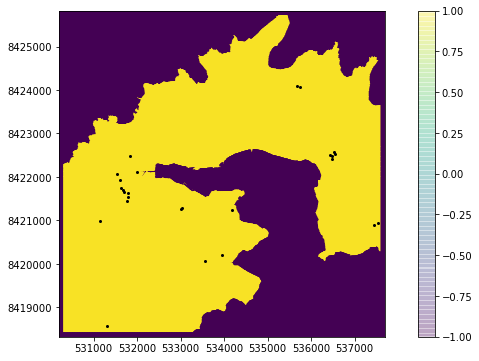

In [8]:
Pdevel_WLs = pd.read_csv(os.path.join("..",  'Data/Raw/Water_levels', 'Predevelop_WLs_MOD_vai183.csv'))

# Cut out observations that are outside of the model square (dont need the y's but could add those too for shoots and giggls
Pdevel_WLs = Pdevel_WLs[Pdevel_WLs['x_utm'] > shp_xmin]
Pdevel_WLs = Pdevel_WLs[Pdevel_WLs['x_utm'] < shp_xmax]

Pdevel_WLs['col_num'] = Pdevel_WLs['x_utm'].apply(lambda x_utm_val: math.ceil((x_utm_val-xll)/delr) )          # this formula calculates the column number based on the x coordinate   Not sure why rows and cols are opposite what you think but they are
Pdevel_WLs['row_num'] = Pdevel_WLs['y_utm'].apply(lambda y_utm_val: (1+nrow)-math.ceil((y_utm_val-yll)/delc) )   # this formula calculates the row number based on the y coordinate 
Pdevel_WLs['rowcol']  = list(zip(Pdevel_WLs.row_num, Pdevel_WLs.col_num))                                      # just make a tuplel of the row and col

# This takes obs wells that occupy the same cell and averages them! 
Unique_WLs = Pdevel_WLs.groupby('rowcol', as_index=False).mean()                                               # Average the duplicate WLs that fall into a single cell, to get one "observed" water level for that cell 

# make new unique names for each obs point
Unique_WLs["name"] = "Obs_"+Unique_WLs.index.map(str)

nobs = len(Unique_WLs['WL_m_MSL']) 
layervals = [0] * nobs
rowvals = list(Unique_WLs['row_num'].astype(int))
colvals = list(Unique_WLs['col_num'].astype(int))
obsvals = list(Unique_WLs['WL_m_MSL'])
obsnames = list(Unique_WLs["name"])

if Plotnsave_plot: 
    gdf = geopandas.GeoDataFrame(Unique_WLs, geometry=geopandas.points_from_xy(Unique_WLs.x_utm, Unique_WLs.y_utm))
    fig, ax = plt.subplots(figsize = (12,6))
    Grid.plot(ax=ax, facecolor="white", edgecolor="Black", linewidth=.2, alpha = .2)
    qm = sr.plot_array(ibound, ax=ax, alpha = .2)
    ax.set_aspect(1); plt.colorbar(qm)
    gdf.plot(ax=ax, color='black', markersize=4)

### Import Recharge .asc from SWB output into MODFLOW rech array

###### TO change to an RCP4.5 Scenario simply change out net_infiltration_annual_Base to  Normalized_RCP4p5_Net_Infil.asc
(note I am not sure what happens when the model area is bigger then the raster....)

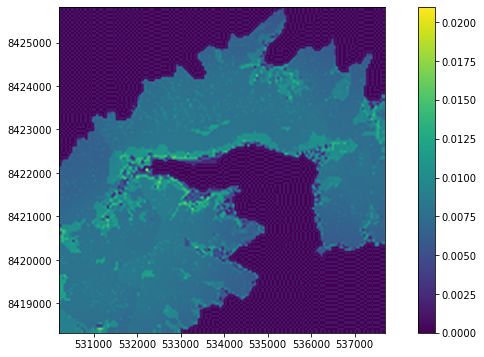

In [55]:
SWB_output_recharge = os.path.join("..",  'Data/Raw/GIS/Recharge','net_infiltration_annual_Base.asc')    # Normalized_RCP4p5_Net_Infil        net_infiltration_annual_Base



# Needed to clip the raster to appropriate dimensions, () https://rasterio.readthedocs.io/en/stable/topics/masking-by-shapefile.html)   
Raster_2_Clip = os.path.join(SWB_output_recharge)
Clipped_raster = os.path.join(workspace, "raw_net_infiltration_clip.asc")

with fiona.open(os.path.join(workspace, 'Model_polyarea.shp'), "r") as shapefile:
    features = [feature["geometry"] for feature in shapefile]
    
with rasterio.open(Raster_2_Clip) as src:
    out_image, out_transform = rasterio.mask.mask(src, features, crop=True)
    
out_meta = src.meta.copy()
out_meta.update({"driver": "AAIGrid",
                 "height": out_image.shape[1],
                 "width": out_image.shape[2],
                 "transform": out_transform})

with rasterio.open(Clipped_raster, "w", **out_meta) as dest:          # create the new clipped .asc file
    dest.write(out_image)
    
# Now disect the clipped .asc into a 
recharge_raw_SWB = np.loadtxt(Clipped_raster, skiprows=6)

y = np.linspace(0, np.shape(recharge_raw_SWB)[0]-1, np.shape(recharge_raw_SWB)[0])   
x = np.linspace(0, np.shape(recharge_raw_SWB)[1]-1, np.shape(recharge_raw_SWB)[1])

y2 = np.linspace(0, np.shape(y)[0], nrow)   # this defines the number of cells to resample to on the y direction, first number is the original height of the SWB2 recharge map, second number is going to be new height in # of cells
x2 = np.linspace(0, np.shape(x)[0], ncol)   # this defines the number of cells to resample to on the x direction, first number is the original width of the SWB2 recharge map, second number is going to be new width in # of cells

f = interp2d(x, y, recharge_raw_SWB, kind='cubic')
recharge_resampled = f(x2, y2)
recharge_converted =  recharge_resampled* (0.0254/365)   # recharge comes out of SWB in inches/year and needs to be converted to m/day

recharge_converted = np.where(recharge_converted < 0, 0.001, recharge_converted)   # Interpolation made some negative values, fix that issue by setting them to a positive value

rch_data = {0: recharge_converted}   # dictionary form to specify that it is only on first layer

if Plotnsave_plot: 
    fig, ax = plt.subplots(figsize = (12,6))
    qm = sr.plot_array(recharge_converted, ax=ax)
    ax.set_aspect(1); plt.colorbar(qm)

### Hydraulic condictivty assigned based on zones as defined by shapefiles in a folder

The values at the top of this cell can be modified to change the conductivity in each zone

In [48]:
# Function to rasterize the HK zones: 
def rastah_zone(shp):
    with fiona.open(shp) as src:   #    read in Tutuila shapefile
            records = [r for r in src]   
    geoms = [r['geometry'] for r in records]       # shapefile shape
    attr = [r['properties'] for r in records]      # shapefile attributes
    geoms = [(g, attr[i]['par_code']) for i, g in enumerate(geoms)]              # select the attribute to map onto the raster grid
    # affine: work with the geometry to change from raster to grid reference frame 
    trans = Affine(delr, rotation, sr.xul, sr.rotation, -delc, sr.yul)
    Outrastah = rasterize(geoms, out_shape=(nrow, ncol), transform=trans) # the actual rasterization 
    return Outrastah

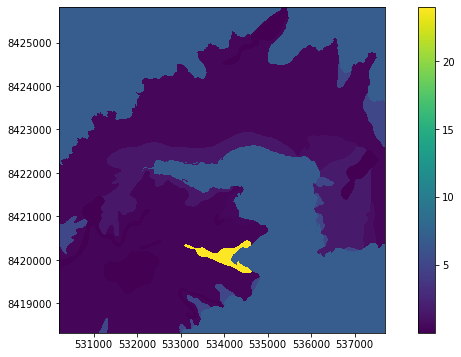

In [11]:
# set the  values this cell is set up for optimization
HK_raster = rastah_zone(os.path.join("..",  'Data/Raw/GIS/Geo_units/v2', 'NPS_simplified_geo_v2.shp'))

## Initial starting point before 3-4 rounds of calibration  was calgood = [ 5, 5, 5, 5, 5, 5, 0.2, .2, .2, .4, 0.5, 5]
#calgood =  [2.6, 39, 1, 14, 3.7, 1.2, 0.001, 0.37, 0.9, 0.7, 0.3, 1], [0.7, 16, 16,  0.5, 1.0, 0.5, 0.002, 0.75, 0.17, 0.3, 0.0018, 3.75] [1.3, 27, 11.5, 0.3, 1.2, 0.27, 0.00158, 0.73, 0.42, 0.38, 0.003 , 1.6] #0.000003 calgood =  [0.89, 24.0, 5.1, 0.5, 1.5, 0.39, 0.002, 1.6, 0.36, 0.43, 0.00039, 0.92]   # manually set the Trachyte to a lower value to avoid Crazy heads  This works

calgood = [0.89, 24.0, 5.1, 0.5, 1.5, 0.39, 0.002, 1.6, 0.36, 0.43, 0.0039, 0.92]#  ~2.6 errort



Alluvium_Aua      = calgood[0]
Alluvium_Fagaalu  = calgood[1]
Alluvium_minor    = calgood[2]
Alluvium_Utulei   = calgood[3]
Alluvium_Vaipito  = calgood[4]
Alluvium_Vatia    = calgood[5]
Dikes             = calgood[6]
Pago_inner_E      = calgood[7]
Pago_inner_W      = calgood[8]
Pago_outer        = calgood[9]
Trachyte          = calgood[10]
Alluvium_Laulii   = calgood[11]


map_dic = {-12:Alluvium_Aua, 
           -14:Alluvium_Fagaalu, 
           -15:Alluvium_minor,
           -13:Alluvium_Utulei,
           -11:Alluvium_Vaipito,
           -10:Alluvium_Vatia,
           -50:Dikes,
           -30:Pago_inner_E,
           -40:Pago_inner_W,
           -20:Pago_outer,
           -60:Trachyte, 
           -16:Alluvium_Laulii}

for i in map_dic:
    HK_raster = np.where(HK_raster== i, map_dic[i], HK_raster)
    
HK_raster = np.where(HK_raster== 0, 7, HK_raster)   # this is for the areas not covered by HK zones, the number Should not actually maatter at all!

#HK_raster = np.where(HK_raster== -90, 1, HK_raster) # this is for the areas that get messed up somehow
#HK_raster = np.where(HK_raster== -70, 1, HK_raster) # this is for the areas that get messed up somehow

if Plotnsave_plot: 
    fig, ax = plt.subplots(figsize = (12,6))
    qm = sr.plot_array(HK_raster, ax=ax)
    ax.set_aspect(1); plt.colorbar(qm)

'''Define the layers to be confined and define the horizontal and vertical 
hydraulic conductivity of the aquifer for the LPF package.'''

# lpf data
laytyp = 0
vka = 10


In [56]:
modelname = 'modelface'

ml = flopy.modflow.Modflow(modelname, version='mf2005', exe_name=exe_name, model_ws=workspace, verbose=False)

discret = flopy.modflow.ModflowDis(ml, nlay=nlay, nrow=nrow, ncol=ncol, laycbd=0,
                                   delr=delr, delc=delc, top=top, botm=botm,
                                   nper=nper, perlen=perlen, nstp=nstp)
bas = flopy.modflow.ModflowBas(ml, ibound=ibound, strt=start_heads)
lpf = flopy.modflow.ModflowLpf(ml, laytyp=laytyp, hk=HK_raster, vka=vka)
#### ghb = flopy.modflow.ModflowGhb(ml, stress_period_data=ghb_data)
rch = flopy.modflow.ModflowRch(ml, rech=rch_data)
oc = flopy.modflow.ModflowOc(ml, stress_period_data=spd)
pcg = flopy.modflow.ModflowPcg(ml, hclose=1.0e-6, rclose=3.0e-3, mxiter=100, iter1=50)
drn = flopy.modflow.ModflowDrn(ml, ipakcb=53, print_flows=True, stress_period_data=stress_period_data_drain)  # ipakcb=53, is flag for writing SFR output to cell-by-cell budget (on unit 53)
wel = flopy.modflow.ModflowWel(model = ml, stress_period_data=stress_period_data_PmpWells)

# water level observations
obs_data= []
for i in range(0,nobs):
    obs = flopy.modflow.HeadObservation(ml, obsname=obsnames[i], layer=layervals[i], row=rowvals[i], column=colvals[i], time_series_data=[[0,obsvals[i]]])
    obs_data.append(obs)
hob = flopy.modflow.ModflowHob(ml, iuhobsv = 7, hobdry=-999, obs_data = obs_data)

# Run model 

if needed: #### Model checker
https://notebook.community/brclark-usgs/flopy/examples/Notebooks/flopy3_ModelCheckerExample
- ml.check()

In [57]:
ml.write_input()
ml.run_model(silent=False)

FloPy is using the following  executable to run the model: .\mf2005.exe

                                  MODFLOW-2005     
    U.S. GEOLOGICAL SURVEY MODULAR FINITE-DIFFERENCE GROUND-WATER FLOW MODEL
                             Version 1.12.00 2/3/2017                        

 Using NAME file: modelface.nam 
 Run start date and time (yyyy/mm/dd hh:mm:ss): 2021/11/14  7:00:48

 Solving:  Stress period:     1    Time step:     1    Ground-Water Flow Eqn.
 Run end date and time (yyyy/mm/dd hh:mm:ss): 2021/11/14  7:02:10
 Elapsed run time:  1 Minutes, 22.151 Seconds

  Normal termination of simulation


(True, [])

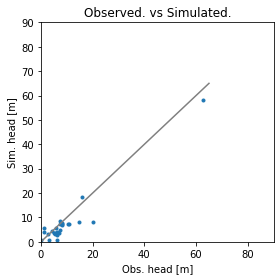

Mean Error: -1.73
Mean Absolute Error: 2.70
RMS Error: 3.69
but remember, the model should be calibrated to a no well scenario, so dont worry about this


In [51]:
# plot observations 
observations = np.loadtxt(os.path.join(workspace, '{}.hob.out'.format(modelname)), skiprows=1, usecols=[0,1])      # this block extracts observation data at each well field and determines what the maximum residual at any of the given points is
comp_obs = np.ravel(np.split(observations, 2, 1)[0]) # the computed hed values at the obspts
obs_obs = np.ravel(np.split(observations, 2, 1)[1]) # the observed hed values at the obspts

# note positive residuals means model is calculating too high negative is model calculates too low 
residuals = []
for idx, i in enumerate(observations):   
    r = observations[idx][0]-observations[idx][1]
    residuals.append(r)

Howd_we_do = pd.DataFrame({"Obs_hed_m":obs_obs,"Comp_hed_m":comp_obs,"Residual_m":residuals})

fig = plt.figure(figsize=(4,4))
plt.title('Observed. vs Simulated.')
plt.plot(Howd_we_do["Obs_hed_m"], Howd_we_do["Comp_hed_m"], '.')
#plt.axis('equal')
#plt.axis('square')
plt.xlabel("Obs. head [m]")
plt.ylabel('Sim. head [m]')
plt.ylim(0,90)
plt.xlim(0,90)

plt.plot([0,20,65],[0,20,65], color= "grey")
plt.tight_layout()
plt.savefig(os.path.join(figurespace, "calibration_result.pdf"))

plt.show()

me = np.mean(Howd_we_do.Residual_m)
mea = np.mean(np.abs(Howd_we_do.Residual_m))
rmse = np.sqrt(np.mean(Howd_we_do.Residual_m**2))
print ('Mean Error: {:.2f}\nMean Absolute Error: {:.2f}\nRMS Error: {:.2f}'.format(me, mea, rmse))
print("but remember, the model should be calibrated to a no well scenario, so dont worry about this") 

## Post process, map and extract results to heads raster file

In [58]:
esri_is_the_lamest_program_ever = "base_RCP45"

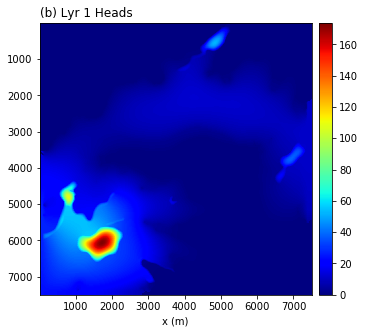

wrote ..\..\RISA_yr6_GIT_ignored_files\Flo_py_wrkspace5p2\heads_base_RCP45.asc


In [59]:
# develop geometry to plot heads as colormap
N = np.array([ncol, nrow, nlay])
dx = np.array([delc, delr, abs(botm)])
Lx = delc*ncol
Ly = delr*nrow
x = np.linspace(0. + dx[0] / 2., Lx - dx[0] / 2., N[0])
y = np.linspace(0. + dx[1] / 2., Ly - dx[1] / 2., N[1])
XX, YY = np.meshgrid(x, y)

# Extract heads data
hds = bf.HeadFile(os.path.join(workspace, '{}.hds'.format(modelname)))
times = hds.get_times() # simulation time, steady state
head = hds.get_data(totim=times[-1])
minv = 0
maxv = head.max()

# Plot em
fig, axes = plt.subplots(1, 1, figsize=(10, 5))
im1 = axes.pcolormesh(XX, YY, head[0], vmin=minv, vmax=maxv, cmap=plt.get_cmap('jet'))
axes.set_title('(b) Lyr 1 Heads', loc='left')
axes.set_xlabel('x (m)')
axes.set_aspect('equal')
axes.axis([XX.min(), XX.max(), YY.max(), YY.min()])
from mpl_toolkits.axes_grid1 import make_axes_locatable
divider = make_axes_locatable(axes)
cbar_ax = divider.append_axes("right", size="5%", pad=0.1)
fig.colorbar(im1, cax=cbar_ax)
plt.show()

# Write the heads layer(s) to a raster file
# export head rasters 
output_raster = os.path.join(workspace, 'heads_{}.asc'.format(esri_is_the_lamest_program_ever))   # if there are multiple layers exports based on each layer
grid = ml.modelgrid
flopy.export.utils.export_array(grid, output_raster, head[0])

# Project the output .asc into WGS84 space with manual  ASC header modification 
new_first = ('ncols {}\n'                        # these are the parameters for the .asc file
             'nrows {}\n'
             'xllcorner {}\n'
             'yllcorner {}\n'
             'cellsize {}\n'
             'NODATA_value -999.0'.format(ncol,nrow, xll, yll, np.mean([delc, delr]) ))

with open(os.path.join('.', output_raster), 'r') as fin:   # open file 
    data = fin.read().splitlines(True)
with open(os.path.join('.', output_raster), 'w') as fout:     # delete first line
    fout.writelines(data[6:])
    
with open(os.path.join('.', output_raster), 'r+') as file:                # add in new first line and save file  
    file_data = file.read()
    file. seek(0, 0)
    file. write(new_first + '\n' + file_data)

### Calculate Depth to water


wrote ..\..\RISA_yr6_GIT_ignored_files\Flo_py_wrkspace5p2\dep2Wat_base_RCP45.asc


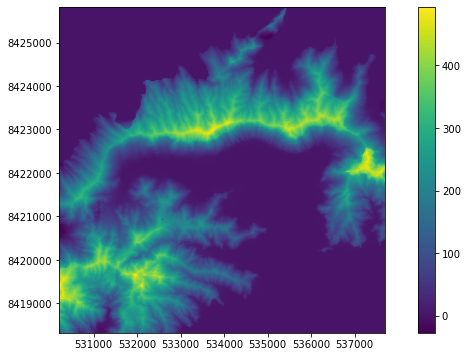

In [60]:
# Super basic depth to water calculation, Currently allows for negative depths (i.e. flooding)
Heads_raw = np.loadtxt(os.path.join(workspace, 'heads_{}.asc'.format(esri_is_the_lamest_program_ever)), skiprows=6)   # the 7th row was a no data row for some reason not sure why, if another DEM is used might need to skiprows back to 6
Dep_to_wat = top-Heads_raw

# Write the GIS asc raster from the NP array 
output_raster = os.path.join(workspace, 'dep2Wat_{}.asc'.format(esri_is_the_lamest_program_ever))   # if there are multiple layers exports based on each layer
grid = ml.modelgrid
flopy.export.utils.export_array(grid, output_raster, Dep_to_wat)

# Project the output .asc into WGS84 space with manual  ASC header modification 
new_first = ('ncols {}\n'                        # these are the parameters for the .asc file
             'nrows {}\n'
             'xllcorner {}\n'
             'yllcorner {}\n'
             'cellsize {}\n'
             'NODATA_value -999.0'.format(ncol,nrow, xll, yll, np.mean([delc, delr]) ))

with open(os.path.join('.', output_raster), 'r') as fin:   # open file 
    data = fin.read().splitlines(True)
with open(os.path.join('.', output_raster), 'w') as fout:     # delete first line
    fout.writelines(data[6:])
    
with open(os.path.join('.', output_raster), 'r+') as file:                # add in new first line and save file  
    file_data = file.read()
    file. seek(0, 0)
    file. write(new_first + '\n' + file_data)
    
    
if Plotnsave_plot: 
    fig, ax = plt.subplots(figsize = (12,6))
    qm = sr.plot_array(Dep_to_wat, ax=ax)
    ax.set_aspect(1); plt.colorbar(qm)

## Run a basic zonal optimzation calibration

In [62]:
def plot_calibrateo(Howd_we_do):
    
    #Plot the OBS plot if want
    fig = plt.figure(figsize=(4,4))
    plt.title('Observed. vs Simulated.')
    plt.plot(Howd_we_do["Obs_hed_m"], Howd_we_do["Comp_hed_m"], '.')
    #plt.axis('equal')
    #plt.axis('square')
    plt.xlabel("Obs. head [m]")
    plt.ylabel('Sim. head [m]')
    plt.ylim(0,90)
    plt.xlim(0,90)
    plt.plot([0,30,65],[0,30,65], color= "grey")
    plt.tight_layout()
    plt.savefig("cal.pdf")
    plt.show()


def calibrateo(params):
    
    Alluvium_Aua, Alluvium_Fagaalu, Alluvium_minor, Alluvium_Utulei, Alluvium_Vaipito, Alluvium_Vatia, Dikes, Pago_inner_E, Pago_inner_W, Pago_outer, Trachyte, Alluvium_Laulii= params   
    
    # set the  values this cell is set up for optimization
    HK_raster = rastah_zone(os.path.join("..",  'Data/Raw/GIS/Geo_units/v2', 'NPS_simplified_geo_v2.shp'))

    map_dic = {-12:Alluvium_Aua, 
               -14:Alluvium_Fagaalu, 
               -15:Alluvium_minor,
               -13:Alluvium_Utulei,
               -11:Alluvium_Vaipito,
               -10:Alluvium_Vatia,
               -50:Dikes,
               -30:Pago_inner_E,
               -40:Pago_inner_W,
               -20:Pago_outer,
               -60:Trachyte,    
               -16:Alluvium_Laulii}

    for i in map_dic:
        HK_raster = np.where(HK_raster== i, map_dic[i], HK_raster)

    HK_raster = np.where(HK_raster== 0, 7, HK_raster)   # this is for the areas not covered by HK zones, Should not actually maatter at all!
    
    
    
    ############    Now generate the run the new model         
    modelname = 'model_pago_OPT'  
        
    ml = flopy.modflow.Modflow(modelname, version='mf2005', exe_name=exe_name, model_ws=workspace, verbose=False)
    
    discret = flopy.modflow.ModflowDis(ml, nlay=nlay, nrow=nrow, ncol=ncol, laycbd=0,
                                       delr=delr, delc=delc, top=top, botm=botm,
                                       nper=nper, perlen=perlen, nstp=nstp)
    
    bas = flopy.modflow.ModflowBas(ml, ibound=ibound, strt=start_heads)
    lpf = flopy.modflow.ModflowLpf(ml, laytyp=laytyp, hk=HK_raster, vka=vka)
    rch = flopy.modflow.ModflowRch(ml, rech=rch_data)
    oc = flopy.modflow.ModflowOc(ml, stress_period_data=spd)
    pcg = flopy.modflow.ModflowPcg(ml, hclose=1.0e-6, rclose=3.0e-3, mxiter=100, iter1=50)
    drn = flopy.modflow.ModflowDrn(ml, ipakcb=53, print_flows=True, stress_period_data=stress_period_data_drain)  # ipakcb=53, is flag for writing SFR output to cell-by-cell budget (on unit 53)
   ######## wel = flopy.modflow.ModflowWel(model = ml, stress_period_data=stress_period_data_PmpWells)


    # water level observations
    obs_data= []
    for i in range(0,nobs):
        obs = flopy.modflow.HeadObservation(ml, obsname=obsnames[i], layer=layervals[i], row=rowvals[i], column=colvals[i], time_series_data=[[0,obsvals[i]]])
        obs_data.append(obs)
    hob = flopy.modflow.ModflowHob(ml, iuhobsv = 7, hobdry=-999, obs_data = obs_data)        
    
    
    # Run da model 
    ml.write_input()
    ml.run_model(silent=True)


    # post process observations 
    observations = np.loadtxt(os.path.join(workspace, '{}.hob.out'.format(modelname)), skiprows=1, usecols=[0,1])      # this block extracts observation data at each well field and determines what the maximum residual at any of the given points is
    comp_obs = np.ravel(np.split(observations, 2, 1)[0]) # the computed hed values at the obspts
    obs_obs = np.ravel(np.split(observations, 2, 1)[1]) # the observed hed values at the obspts

    # note positive residuals means model is calculating too high negative is model calculates too low 
    residuals = []
    for idx, i in enumerate(observations):   
        r = observations[idx][0]-observations[idx][1]
        residuals.append(r)

    Howd_we_do = pd.DataFrame({"Obs_hed_m":obs_obs,"Comp_hed_m":comp_obs,"Residual_m":residuals})
    # error metrics
    me = np.mean(Howd_we_do.Residual_m)
    mea = np.mean(np.abs(Howd_we_do.Residual_m))
    rmse = np.sqrt(np.mean(Howd_we_do.Residual_m**2))
    
    
    # Plot if want
    plot_calibrateo(Howd_we_do)

    print("Error is - {}".format(rmse))
    print("Params are - {}".format(params))
    return rmse






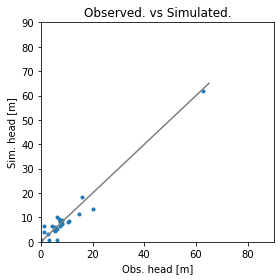

Error is - 2.610166602332187
Params are - [0.89, 24.0, 5.1, 0.5, 1.5, 0.39, 0.002, 1.6, 0.36, 0.43, 0.0039, 0.92]


2.610166602332187

In [63]:
# Run once 
# params = [4.6, 13.0, 0.1, 5.0, 2.6, 0.4, 0.3, 0.1, 0.5, 0.6, 0.3]
params = [2.6, 39, 1, 14, 3.7, 1.2, 0.001, 0.37, 0.9, 0.7, 0.3, 1]
params = [0.7, 32, 6.8, 1.9, 1.5, 5.0, 0.001, 1.0, 0.25, 0.2, 0.0015, 2.5] 

#[0.7, 32, 6.8, 1.9, 1.5, 5.0, 0.001, 1.0, 0.25, 0.2, 0.0015, 2.5] 

#[1.3, 27, 11.5, 0.3, 1.2, 0.27, 0.00158, 0.73, 0.42, 0.38, 0.000003, 1.6]   error of 57.5?? WTF

params =  [0.89, 24.0, 5.1, 0.5, 1.5, 0.39, 0.002, 1.6, 0.36, 0.43, 0.0039, 0.92]

calibrateo(params)

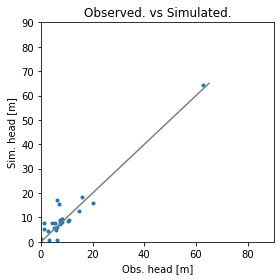

Error is - 3.6701375043850715
Params are - [7.00e-01 1.60e+01 1.60e+01 5.00e-01 1.00e+00 5.00e-01 2.30e-03 7.00e-01
 1.70e-01 3.00e-01 1.70e-03 3.75e+00]


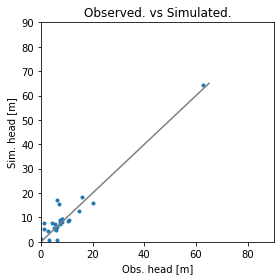

Error is - 3.6618563861044304
Params are - [7.35e-01 1.60e+01 1.60e+01 5.00e-01 1.00e+00 5.00e-01 2.30e-03 7.00e-01
 1.70e-01 3.00e-01 1.70e-03 3.75e+00]


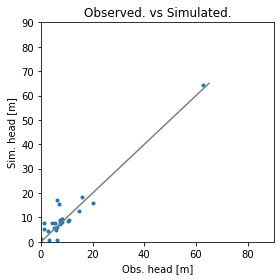

Error is - 3.662068629492208
Params are - [7.00e-01 1.68e+01 1.60e+01 5.00e-01 1.00e+00 5.00e-01 2.30e-03 7.00e-01
 1.70e-01 3.00e-01 1.70e-03 3.75e+00]


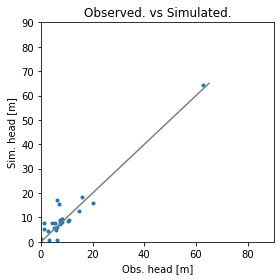

Error is - 3.6704150201297034
Params are - [7.00e-01 1.60e+01 1.68e+01 5.00e-01 1.00e+00 5.00e-01 2.30e-03 7.00e-01
 1.70e-01 3.00e-01 1.70e-03 3.75e+00]


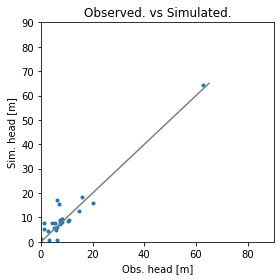

Error is - 3.669467445239961
Params are - [7.00e-01 1.60e+01 1.60e+01 5.25e-01 1.00e+00 5.00e-01 2.30e-03 7.00e-01
 1.70e-01 3.00e-01 1.70e-03 3.75e+00]


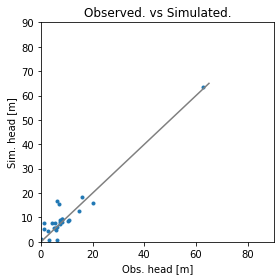

Error is - 3.611329783532481
Params are - [7.00e-01 1.60e+01 1.60e+01 5.00e-01 1.05e+00 5.00e-01 2.30e-03 7.00e-01
 1.70e-01 3.00e-01 1.70e-03 3.75e+00]


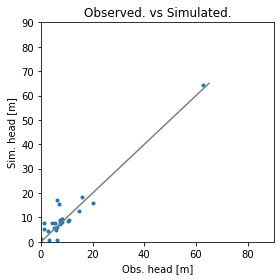

Error is - 3.669030014849548
Params are - [7.00e-01 1.60e+01 1.60e+01 5.00e-01 1.00e+00 5.25e-01 2.30e-03 7.00e-01
 1.70e-01 3.00e-01 1.70e-03 3.75e+00]


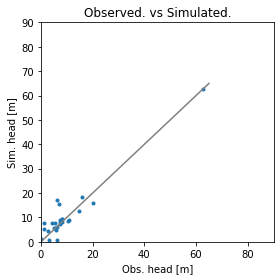

Error is - 3.650358747306886
Params are - [7.000e-01 1.600e+01 1.600e+01 5.000e-01 1.000e+00 5.000e-01 2.415e-03
 7.000e-01 1.700e-01 3.000e-01 1.700e-03 3.750e+00]


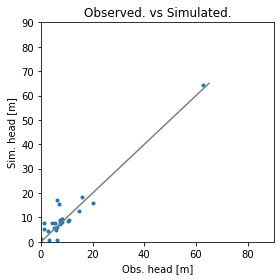

Error is - 3.6673935424079063
Params are - [7.00e-01 1.60e+01 1.60e+01 5.00e-01 1.00e+00 5.00e-01 2.30e-03 7.35e-01
 1.70e-01 3.00e-01 1.70e-03 3.75e+00]


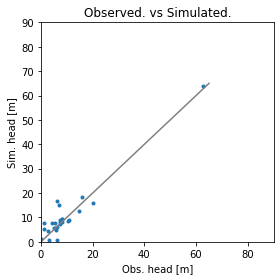

Error is - 3.5846048454683967
Params are - [7.000e-01 1.600e+01 1.600e+01 5.000e-01 1.000e+00 5.000e-01 2.300e-03
 7.000e-01 1.785e-01 3.000e-01 1.700e-03 3.750e+00]


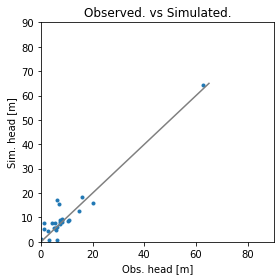

Error is - 3.6600918443570998
Params are - [7.00e-01 1.60e+01 1.60e+01 5.00e-01 1.00e+00 5.00e-01 2.30e-03 7.00e-01
 1.70e-01 3.15e-01 1.70e-03 3.75e+00]


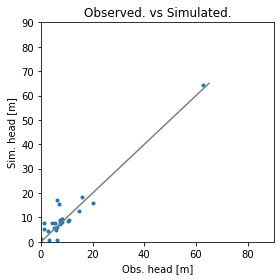

Error is - 3.671457842673844
Params are - [7.000e-01 1.600e+01 1.600e+01 5.000e-01 1.000e+00 5.000e-01 2.300e-03
 7.000e-01 1.700e-01 3.000e-01 1.785e-03 3.750e+00]


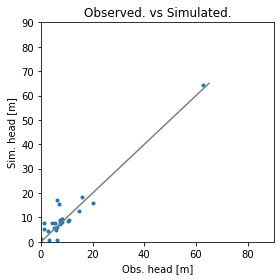

Error is - 3.670804716119768
Params are - [7.0000e-01 1.6000e+01 1.6000e+01 5.0000e-01 1.0000e+00 5.0000e-01
 2.3000e-03 7.0000e-01 1.7000e-01 3.0000e-01 1.7000e-03 3.9375e+00]


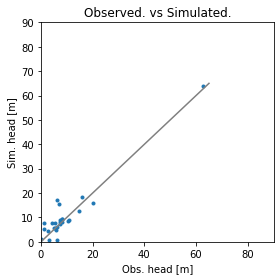

Error is - 3.6334775566496074
Params are - [7.05833333e-01 1.61333333e+01 1.61333333e+01 5.04166667e-01
 1.00833333e+00 5.04166667e-01 2.31916667e-03 7.05833333e-01
 1.71416667e-01 3.02500000e-01 1.61500000e-03 3.78125000e+00]


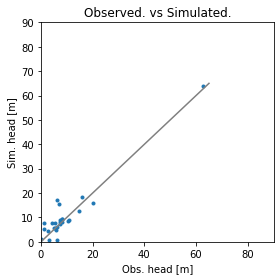

Error is - 3.6282262248211845
Params are - [7.06805556e-01 1.61555556e+01 1.61555556e+01 5.04861111e-01
 1.00972222e+00 5.04861111e-01 2.32236111e-03 7.06805556e-01
 1.71652778e-01 3.02916667e-01 1.68583333e-03 3.56770833e+00]


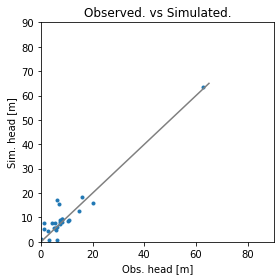

Error is - 3.621897801953503
Params are - [7.07939815e-01 1.61814815e+01 1.52481481e+01 5.05671296e-01
 1.01134259e+00 5.05671296e-01 2.32608796e-03 7.07939815e-01
 1.71928241e-01 3.03402778e-01 1.68347222e-03 3.72482639e+00]


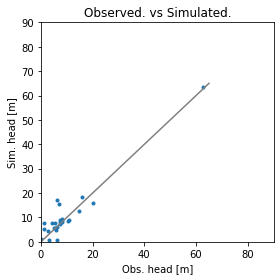

Error is - 3.614485786055722
Params are - [7.09263117e-01 1.62117284e+01 1.59228395e+01 5.06616512e-01
 1.01323302e+00 5.06616512e-01 2.33043596e-03 7.09263117e-01
 1.72249614e-01 3.03969907e-01 1.68071759e-03 3.72063079e+00]


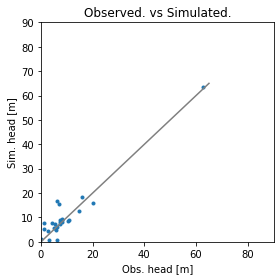

Error is - 3.606608931250062
Params are - [7.10806970e-01 1.62470165e+01 1.59099794e+01 4.78552598e-01
 1.01543853e+00 5.07719264e-01 2.33550862e-03 7.10806970e-01
 1.72624550e-01 3.04631559e-01 1.67750386e-03 3.71573592e+00]


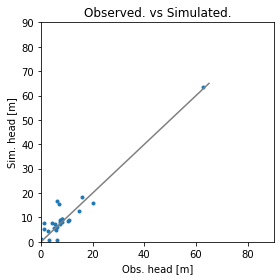

Error is - 3.5973773811096366
Params are - [7.12608132e-01 1.62881859e+01 1.58949760e+01 4.99978031e-01
 1.01801162e+00 4.79839142e-01 2.34142672e-03 7.12608132e-01
 1.73061975e-01 3.05403485e-01 1.67375450e-03 3.71002524e+00]


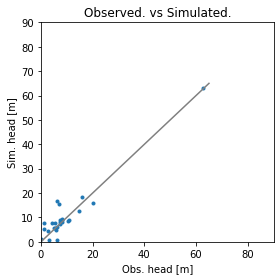

Error is - 3.58839010224074
Params are - [7.14709487e-01 1.63362168e+01 1.58774720e+01 4.99974369e-01
 1.02101355e+00 5.01478999e-01 2.34833117e-03 6.73876154e-01
 1.73572304e-01 3.06304066e-01 1.66938025e-03 3.70336278e+00]


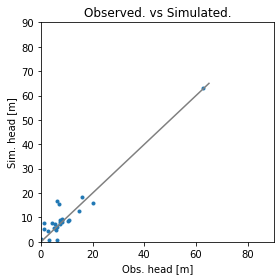

Error is - 3.583366718275741
Params are - [7.17161068e-01 1.54589197e+01 1.58570507e+01 4.99970097e-01
 1.02451581e+00 5.01725499e-01 2.35638637e-03 7.04522179e-01
 1.74167688e-01 3.07354744e-01 1.66427696e-03 3.69558991e+00]


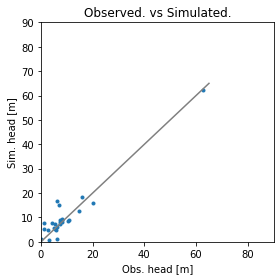

Error is - 3.552554702627417
Params are - [7.25741603e-01 1.47883795e+01 1.57855760e+01 4.99955146e-01
 1.03677372e+00 5.02588248e-01 2.38457955e-03 7.06783269e-01
 1.76251532e-01 3.11032115e-01 1.64641544e-03 3.66838486e+00]


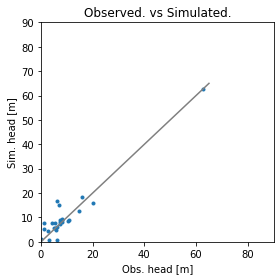

Error is - 3.5669474439458853
Params are - [6.80618002e-01 1.60569829e+01 1.58213133e+01 4.99962622e-01
 1.03064476e+00 5.02156873e-01 2.37048296e-03 7.05652724e-01
 1.75209610e-01 3.09193429e-01 1.65534620e-03 3.68198738e+00]


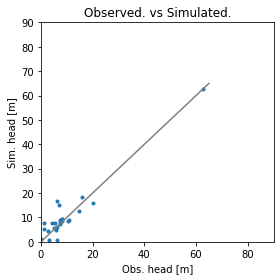

Error is - 3.5548890066154244
Params are - [7.12387669e-01 1.60664801e+01 1.57915322e+01 4.99956392e-01
 1.03575223e+00 5.02516352e-01 2.38223012e-03 7.06594845e-01
 1.76077878e-01 2.93225668e-01 1.64790390e-03 3.67065195e+00]


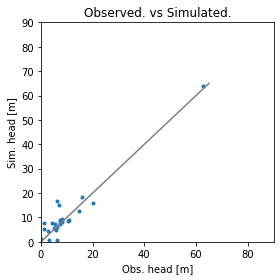

Error is - 3.548572339809862
Params are - [7.14452281e-01 1.60775601e+01 1.57567876e+01 4.99949124e-01
 1.04171093e+00 5.02935744e-01 2.26176847e-03 7.07693986e-01
 1.77090858e-01 3.07096612e-01 1.63922122e-03 3.65742727e+00]


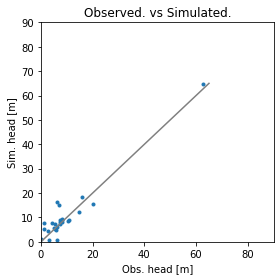

Error is - 3.5140868138241537
Params are - [7.21678421e-01 1.61163401e+01 1.56351814e+01 4.99923686e-01
 1.06256640e+00 5.04403616e-01 2.18515271e-03 7.11540979e-01
 1.80636287e-01 3.10644919e-01 1.60883182e-03 3.61114091e+00]


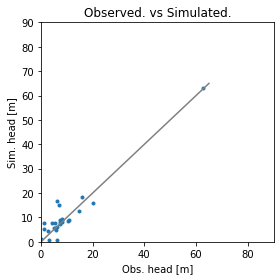

Error is - 3.536474997975294
Params are - [7.11259795e-01 1.59413945e+01 1.55404289e+01 4.95075294e-01
 1.04241644e+00 4.98808569e-01 2.33526615e-03 7.02811927e-01
 1.77210795e-01 3.05954099e-01 1.72319319e-03 3.59782576e+00]


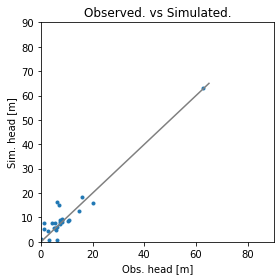

Error is - 3.526837069069229
Params are - [7.11029946e-01 1.58834788e+01 1.54156856e+01 4.92749880e-01
 1.04647659e+00 4.97105368e-01 2.33422254e-03 7.01174100e-01
 1.77901020e-01 3.06043671e-01 1.65858650e-03 3.81638699e+00]


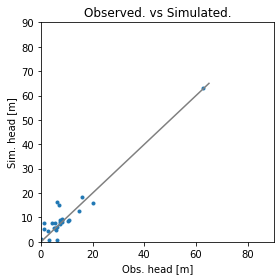

Error is - 3.5174824524010404
Params are - [7.10410709e-01 1.58078858e+01 1.63510159e+01 4.89786125e-01
 1.05071188e+00 4.94867528e-01 2.33185145e-03 6.98912221e-01
 1.78621020e-01 3.05997709e-01 1.65679999e-03 3.67452904e+00]


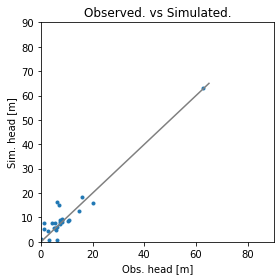

Error is - 3.5088182377005643
Params are - [7.09278672e-01 1.57103317e+01 1.57476873e+01 4.86035845e-01
 1.05506793e+00 4.91964147e-01 2.32773937e-03 6.95863770e-01
 1.79361548e-01 3.05768546e-01 1.65556835e-03 3.67104102e+00]


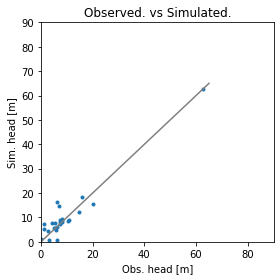

Error is - 3.4620228184641197
Params are - [7.09286449e-01 1.54596334e+01 1.56601112e+01 4.75745511e-01
 1.07598538e+00 4.84637965e-01 2.32639108e-03 6.89164096e-01
 1.82917514e-01 3.06667865e-01 1.64299373e-03 3.64624613e+00]


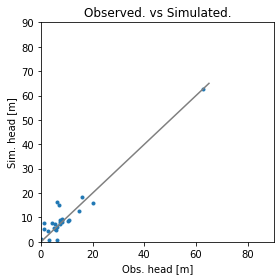

Error is - 3.4908729328435713
Params are - [7.20089531e-01 1.58319990e+01 1.56138786e+01 4.88609942e-01
 1.02263185e+00 4.96020321e-01 2.36257384e-03 7.03320903e-01
 1.83764081e-01 3.10849764e-01 1.62678489e-03 3.62437949e+00]


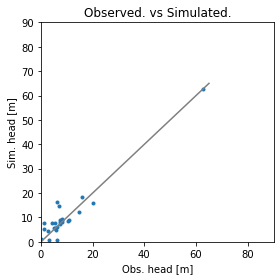

Error is - 3.4742224605084817
Params are - [7.10829654e-01 1.55158130e+01 1.56545491e+01 5.11733568e-01
 1.05839221e+00 4.86351232e-01 2.33157610e-03 6.91266255e-01
 1.82996120e-01 3.07254573e-01 1.64082788e-03 3.64341750e+00]


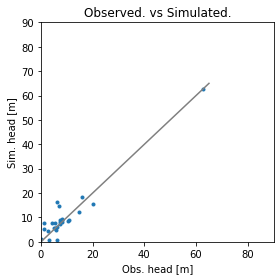

Error is - 3.463269630228327
Params are - [7.08732079e-01 1.53459148e+01 1.56294814e+01 4.92267392e-01
 1.06254922e+00 5.15316703e-01 2.32401623e-03 6.85908114e-01
 1.84214385e-01 3.06791161e-01 1.63908946e-03 3.63802690e+00]


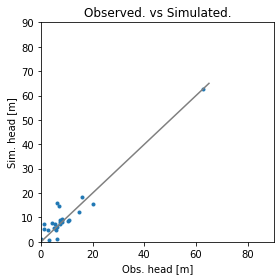

Error is - 3.451413743392461
Params are - [7.05634489e-01 1.51328335e+01 1.56056536e+01 4.90986557e-01
 1.06646989e+00 4.95983130e-01 2.31305928e-03 7.26645418e-01
 1.85477736e-01 3.05971763e-01 1.63841525e-03 3.63380004e+00]


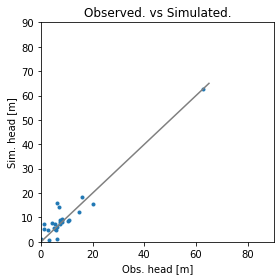

Error is - 3.3925646329576304
Params are - [7.01096990e-01 1.45311418e+01 1.54697444e+01 4.86492651e-01
 1.08919806e+00 4.93235196e-01 2.29542334e-03 7.53030050e-01
 1.91430453e-01 3.05805611e-01 1.62293275e-03 3.59901867e+00]


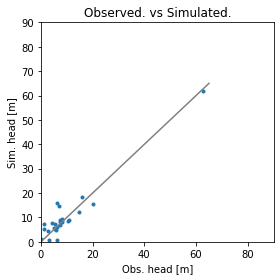

Error is - 3.4346777336373733
Params are - [7.20526808e-01 1.52242406e+01 1.53947497e+01 4.88709701e-01
 1.10234979e+00 4.96334662e-01 2.36062768e-03 7.09359914e-01
 1.82705116e-01 3.13243431e-01 1.59495096e-03 3.56199927e+00]


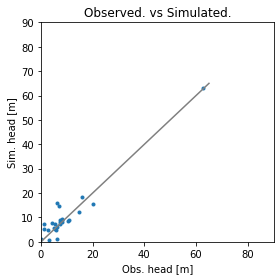

Error is - 3.418245875625128
Params are - [7.46560274e-01 1.50284673e+01 1.55023424e+01 4.86871593e-01
 1.08365586e+00 4.93207420e-01 2.28850217e-03 7.04325054e-01
 1.87244757e-01 3.04725001e-01 1.62953888e-03 3.61001386e+00]


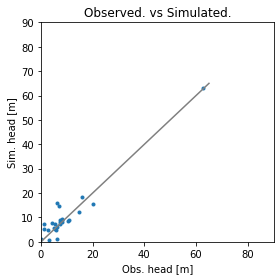

Error is - 3.4104510799531953
Params are - [7.20486041e-01 1.48459680e+01 1.54839252e+01 4.84697023e-01
 1.08653234e+00 4.91296452e-01 2.26113369e-03 7.03004635e-01
 1.88237635e-01 3.22609319e-01 1.63392035e-03 3.61124295e+00]


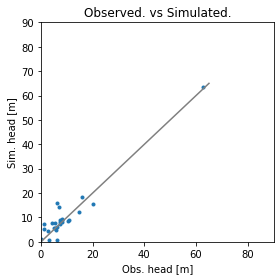

Error is - 3.3920452840877298
Params are - [7.06256180e-01 1.61336667e+01 1.54396063e+01 4.82155248e-01
 1.09380395e+00 4.89342591e-01 2.23820995e-03 7.02186439e-01
 1.90061665e-01 3.06732405e-01 1.63332629e-03 3.60398639e+00]


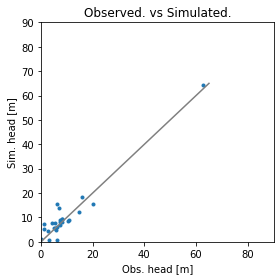

Error is - 3.33252262101125
Params are - [6.96513469e-01 1.68063103e+01 1.52666215e+01 4.73255300e-01
 1.12231907e+00 4.82719762e-01 2.16502514e-03 6.99888024e-01
 1.96966732e-01 3.04582549e-01 1.62678172e-03 3.57178715e+00]


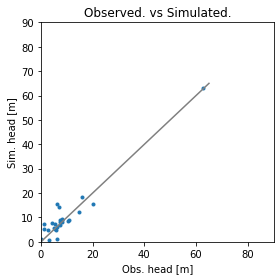

Error is - 3.367092107507631
Params are - [7.18280267e-01 1.51248043e+01 1.56391188e+01 4.83398435e-01
 1.10147833e+00 4.90440802e-01 2.25914985e-03 7.05670464e-01
 1.92395058e-01 3.11581830e-01 1.54047996e-03 3.67020572e+00]


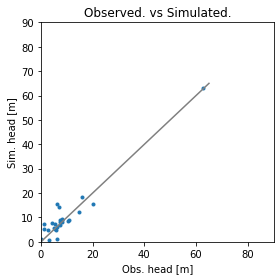

Error is - 3.351286633548075
Params are - [7.19718502e-01 1.50562743e+01 1.58011010e+01 4.84165275e-01
 1.10658514e+00 4.91033242e-01 2.24768134e-03 7.08057685e-01
 1.94120506e-01 3.12415284e-01 1.58540223e-03 3.42728094e+00]


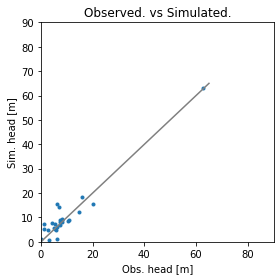

Error is - 3.3342852225922104
Params are - [7.21889038e-01 1.50065987e+01 1.47741182e+01 4.86192221e-01
 1.11166206e+00 4.92632035e-01 2.23602408e-03 7.11843807e-01
 1.95983754e-01 3.13530843e-01 1.57528912e-03 3.52793088e+00]


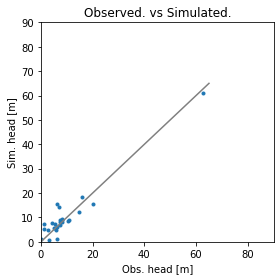

Error is - 3.348337425248091
Params are - [7.10656429e-01 1.45131875e+01 1.53464422e+01 4.73766083e-01
 1.10799015e+00 4.81134016e-01 2.39120138e-03 6.99265521e-01
 1.96526398e-01 3.09364620e-01 1.61766683e-03 3.57745067e+00]


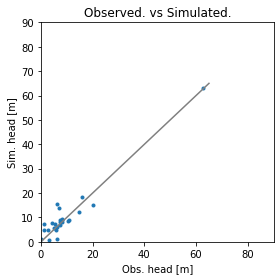

Error is - 3.311082874636849
Params are - [7.10673136e-01 1.45777266e+01 1.53231722e+01 4.82605850e-01
 1.16215108e+00 4.87036260e-01 2.21855150e-03 7.06809700e-01
 1.95525657e-01 3.08912250e-01 1.59819408e-03 3.55639061e+00]


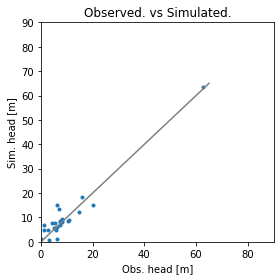

Error is - 3.240010587716353
Params are - [7.05964939e-01 1.39505904e+01 1.51778190e+01 4.79603804e-01
 1.23191070e+00 4.82544230e-01 2.14654033e-03 7.08554099e-01
 2.01406445e-01 3.07943494e-01 1.58389867e-03 3.52239617e+00]


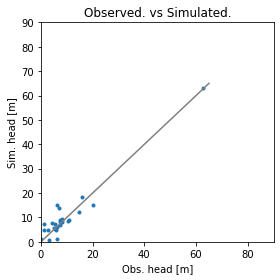

Error is - 3.2838194392645614
Params are - [7.19122227e-01 1.46330423e+01 1.52030467e+01 4.54127263e-01
 1.15531048e+00 4.96070849e-01 2.21870995e-03 7.21745656e-01
 1.99362006e-01 3.12622262e-01 1.57466290e-03 3.51718238e+00]


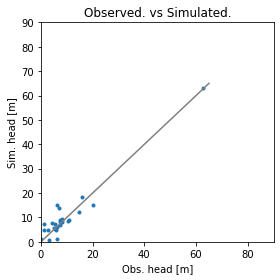

Error is - 3.2654616573546322
Params are - [7.22951493e-01 1.46841284e+01 1.51570420e+01 4.67236751e-01
 1.16661367e+00 4.63897735e-01 2.20871878e-03 7.33076721e-01
 2.00668344e-01 3.14057523e-01 1.56566355e-03 3.50243224e+00]


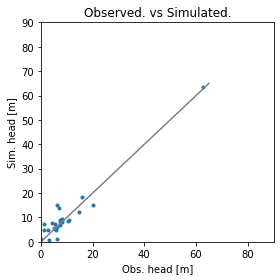

Error is - 3.239880994131379
Params are - [7.24674630e-01 1.44411589e+01 1.50425673e+01 4.82340506e-01
 1.16828223e+00 4.91119768e-01 2.18673187e-03 7.37139509e-01
 2.04923686e-01 3.15412429e-01 1.54887093e-03 3.47024402e+00]


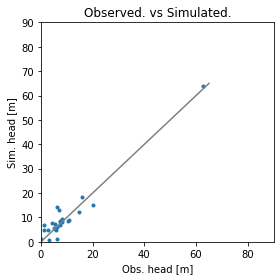

Error is - 3.154416997234882
Params are - [7.32368721e-01 1.39319217e+01 1.47337954e+01 4.85638003e-01
 1.21443065e+00 4.94360670e-01 2.11690227e-03 7.61127216e-01
 2.15926772e-01 3.19784712e-01 1.50180953e-03 3.38224296e+00]


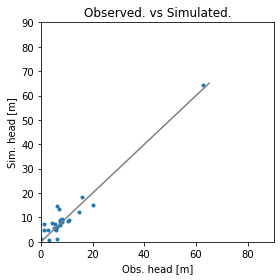

Error is - 3.2398338453840907
Params are - [7.15407923e-01 1.44611652e+01 1.51977698e+01 4.68864365e-01
 1.16059796e+00 4.79094073e-01 2.11187437e-03 7.25571575e-01
 2.10673027e-01 3.09927077e-01 1.58139013e-03 3.52453150e+00]


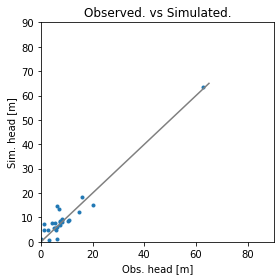

Error is - 3.203964615964725
Params are - [6.84182400e-01 1.45623882e+01 1.50394150e+01 4.67701269e-01
 1.19211558e+00 4.79869090e-01 2.15456191e-03 7.34147521e-01
 2.10038098e-01 3.19312519e-01 1.53877741e-03 3.46226984e+00]


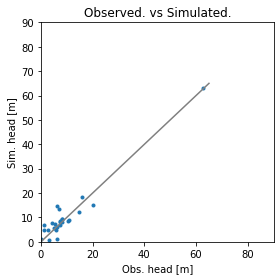

Error is - 3.1784150434073175
Params are - [7.04206026e-01 1.46976241e+01 1.49837471e+01 4.67043214e-01
 1.20683630e+00 4.79875498e-01 2.16416844e-03 7.40658421e-01
 2.12678631e-01 3.00878735e-01 1.51853879e-03 3.43621190e+00]


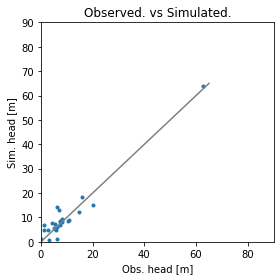

Error is - 3.163550997174997
Params are - [7.24113249e-01 1.50401975e+01 1.49169283e+01 4.62006013e-01
 1.22377695e+00 4.75710138e-01 2.10800297e-03 6.88571068e-01
 2.13027176e-01 3.16861297e-01 1.51212739e-03 3.42130172e+00]


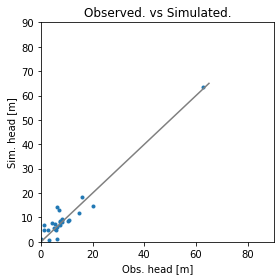

Error is - 3.1509711883456
Params are - [7.07902136e-01 1.44324338e+01 1.46271889e+01 4.61534825e-01
 1.23187979e+00 4.76049421e-01 2.11908531e-03 7.33080755e-01
 2.15501256e-01 3.11964989e-01 1.58985475e-03 3.30863067e+00]


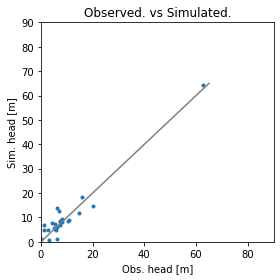

Error is - 3.073976133212823
Params are - [7.02713071e-01 1.40862485e+01 1.41212239e+01 4.50603020e-01
 1.29708052e+00 4.68853731e-01 2.04905304e-03 7.46785901e-01
 2.27054356e-01 3.12156569e-01 1.61454214e-03 3.12784314e+00]


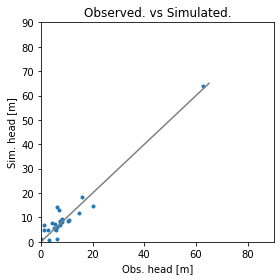

Error is - 3.1206633472966865
Params are - [7.03629662e-01 1.43392929e+01 1.41852272e+01 4.55174276e-01
 1.25852221e+00 4.71760396e-01 2.09744910e-03 7.37148237e-01
 2.19264783e-01 3.11088416e-01 1.54978913e-03 3.50164915e+00]


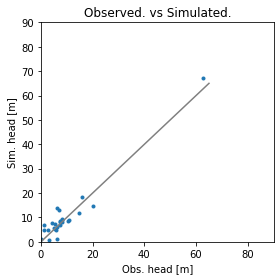

Error is - 3.2170999227791794
Params are - [7.11520607e-01 1.48533972e+01 1.44463501e+01 4.62474834e-01
 1.28220587e+00 4.80097352e-01 1.90497035e-03 7.52254186e-01
 2.20648623e-01 3.14426380e-01 1.50621158e-03 3.33884584e+00]


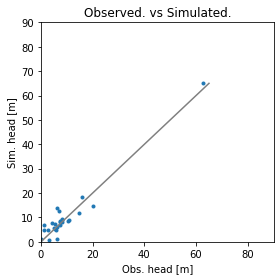

Error is - 3.0974881790818896
Params are - [6.98559926e-01 1.43344524e+01 1.49640461e+01 4.46095798e-01
 1.30695794e+00 4.66510219e-01 2.00497203e-03 7.46410963e-01
 2.25302078e-01 3.10409413e-01 1.53707637e-03 3.35685146e+00]


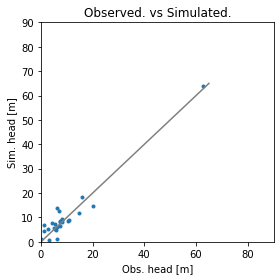

Error is - 3.06139625936176
Params are - [7.24276571e-01 1.21227645e+01 1.44211136e+01 4.54506136e-01
 1.32707407e+00 4.73720902e-01 2.04929545e-03 7.66120570e-01
 2.29041658e-01 3.20328850e-01 1.47063288e-03 3.27717257e+00]


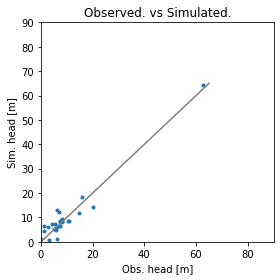

Error is - 2.9985502514188815
Params are - [7.38158123e-01 9.78099154e+00 1.39983597e+01 4.45131553e-01
 1.42945158e+00 4.69221471e-01 1.99143060e-03 7.99236844e-01
 2.45079121e-01 3.28202000e-01 1.39255846e-03 3.12986528e+00]


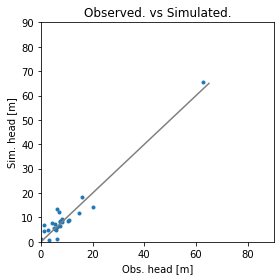

Error is - 3.067342835017954
Params are - [7.04840463e-01 1.34873574e+01 1.42839072e+01 4.72134887e-01
 1.33977285e+00 4.55894919e-01 1.95773075e-03 7.57178136e-01
 2.34265903e-01 3.14885761e-01 1.49240096e-03 3.26722448e+00]


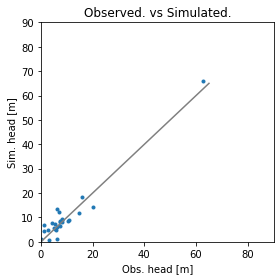

Error is - 3.0676773924957135
Params are - [6.97992692e-01 1.32368095e+01 1.41843895e+01 4.59841755e-01
 1.35732951e+00 4.86734229e-01 1.92589058e-03 7.49863974e-01
 2.38559159e-01 3.13588539e-01 1.48918987e-03 3.24277334e+00]


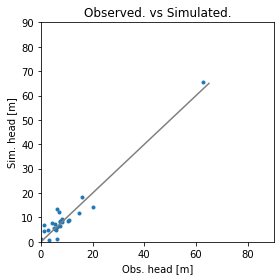

Error is - 3.0356030295623984
Params are - [7.13650538e-01 1.38513839e+01 1.39980410e+01 4.44181028e-01
 1.31293562e+00 4.68786067e-01 1.95129407e-03 7.81271575e-01
 2.44013176e-01 3.20643410e-01 1.45516995e-03 3.17620559e+00]


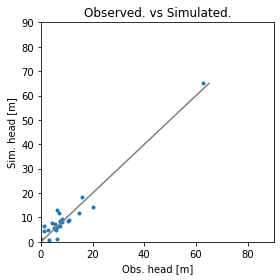

Error is - 2.9938008115571164
Params are - [7.03914656e-01 1.32391789e+01 1.37781353e+01 4.50806576e-01
 1.40963797e+00 4.70518224e-01 1.95919664e-03 7.73537432e-01
 2.40303285e-01 3.20445881e-01 1.43664180e-03 3.11601595e+00]


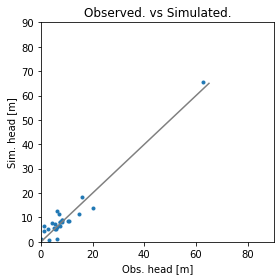

Error is - 2.936057569746865
Params are - [6.98168022e-01 1.26281857e+01 1.30683181e+01 4.41777682e-01
 1.53415797e+00 4.66230299e-01 1.88285778e-03 7.97520361e-01
 2.55118414e-01 3.25705283e-01 1.36426764e-03 2.91175818e+00]


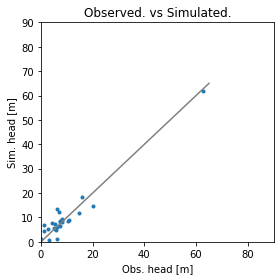

Error is - 3.016392956717759
Params are - [7.05576542e-01 1.24760783e+01 1.42998830e+01 4.53746583e-01
 1.33002207e+00 4.67203769e-01 2.16241524e-03 7.54399183e-01
 2.36072655e-01 3.17826396e-01 1.48816303e-03 3.23052034e+00]


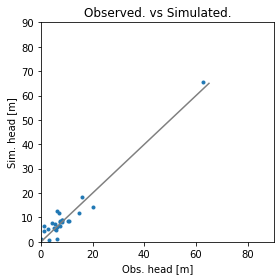

Error is - 2.973932240288534
Params are - [7.36480439e-01 1.24193691e+01 1.35835628e+01 4.46194366e-01
 1.44309679e+00 4.65321144e-01 1.91413256e-03 7.75881125e-01
 2.51022272e-01 3.12692569e-01 1.44716147e-03 3.06847141e+00]


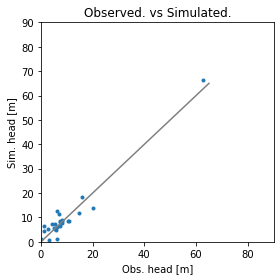

Error is - 2.9971708561028803
Params are - [7.21835882e-01 1.19044239e+01 1.34058666e+01 4.43377614e-01
 1.46775280e+00 4.62889011e-01 1.86285340e-03 7.75240676e-01
 2.54772347e-01 3.33095325e-01 1.45550387e-03 3.03323927e+00]


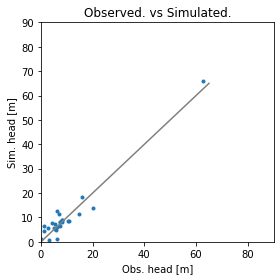

Error is - 2.966490460947396
Params are - [7.01549098e-01 1.10392217e+01 1.32208417e+01 4.45310081e-01
 1.49147480e+00 4.64917517e-01 1.87816060e-03 8.41772964e-01
 2.61381330e-01 3.19818435e-01 1.45247801e-03 2.98347238e+00]


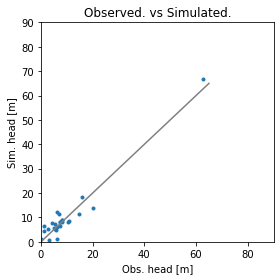

Error is - 2.975780799075504
Params are - [6.88157022e-01 1.16653808e+01 1.31518157e+01 4.14956771e-01
 1.54699512e+00 4.41359792e-01 1.82947103e-03 7.82657774e-01
 2.66057494e-01 3.16900641e-01 1.45457396e-03 2.95606938e+00]


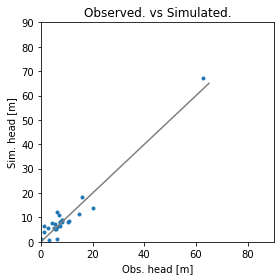

Error is - 2.9904103416798655
Params are - [7.14317308e-01 1.08123576e+01 1.35281487e+01 4.38717580e-01
 1.55098239e+00 4.58893299e-01 1.80426118e-03 8.14221676e-01
 2.70518268e-01 3.26565641e-01 1.39072516e-03 2.74573322e+00]


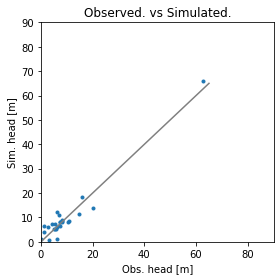

Error is - 2.929522990163111
Params are - [7.22013274e-01 1.02301823e+01 1.25100135e+01 4.46566355e-01
 1.54321740e+00 4.62873989e-01 1.86328644e-03 8.16260735e-01
 2.72017004e-01 3.29937349e-01 1.37904605e-03 2.78867788e+00]


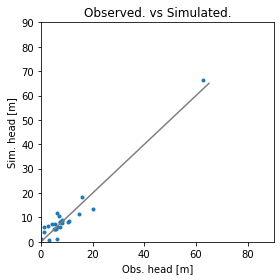

Error is - 2.9347902514072577
Params are - [7.33739948e-01 8.17804725e+00 1.12829972e+01 4.46801634e-01
 1.66134712e+00 4.61055874e-01 1.79244364e-03 8.51185620e-01
 2.95374467e-01 3.39701317e-01 1.30003089e-03 2.50459109e+00]


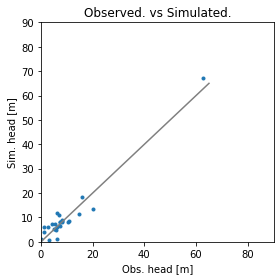

Error is - 2.983956586316351
Params are - [7.21076829e-01 9.83570841e+00 1.30843007e+01 4.41386355e-01
 1.59411763e+00 4.59533854e-01 1.78824433e-03 8.27464936e-01
 2.77758502e-01 3.31153656e-01 1.26233094e-03 2.96115865e+00]


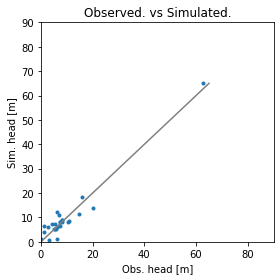

Error is - 2.8921505792348974
Params are - [7.29644565e-01 1.01182973e+01 1.28377870e+01 4.29071721e-01
 1.57333332e+00 4.37119959e-01 1.88846575e-03 8.37320357e-01
 2.72786923e-01 3.32649206e-01 1.34987338e-03 2.79929267e+00]


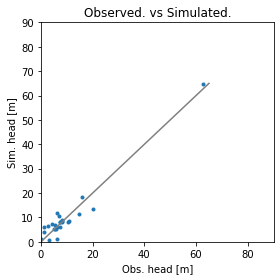

Error is - 2.8524371518179223
Params are - [7.45470501e-01 8.55904125e+00 1.21644857e+01 4.13686704e-01
 1.68133523e+00 4.12312824e-01 1.86975333e-03 8.81048548e-01
 2.89900804e-01 3.42179539e-01 1.28021513e-03 2.57755234e+00]


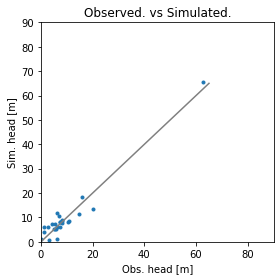

Error is - 2.888302859086475
Params are - [7.29568467e-01 9.04636333e+00 1.23850323e+01 4.07037225e-01
 1.64781705e+00 4.60695587e-01 1.84196268e-03 8.50651263e-01
 2.86352662e-01 3.35900946e-01 1.31129799e-03 2.65989617e+00]


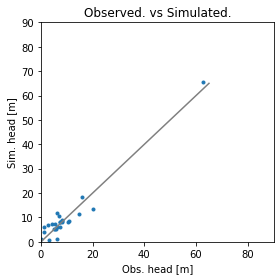

Error is - 2.9134308292729494
Params are - [7.23411380e-01 7.88150009e+00 1.24020638e+01 4.28800451e-01
 1.73046785e+00 4.46456025e-01 1.83017746e-03 8.38121106e-01
 2.83661970e-01 3.32686221e-01 1.32455033e-03 2.66486349e+00]


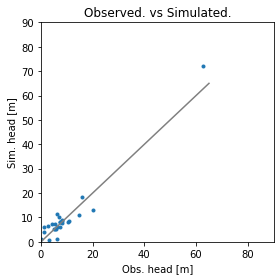

Error is - 3.3854314534189576
Params are - [7.34457849e-01 8.49104260e+00 1.17839186e+01 4.15077207e-01
 1.78012236e+00 4.44580366e-01 1.56368332e-03 8.78947151e-01
 2.99534043e-01 3.37979872e-01 1.26428848e-03 2.51627260e+00]


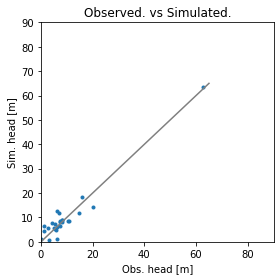

Error is - 2.9325873031367613
Params are - [7.12796868e-01 1.14798194e+01 1.36708919e+01 4.44079239e-01
 1.44254714e+00 4.61547919e-01 2.01273226e-03 7.85536175e-01
 2.51938002e-01 3.22864765e-01 1.43219439e-03 3.05195840e+00]


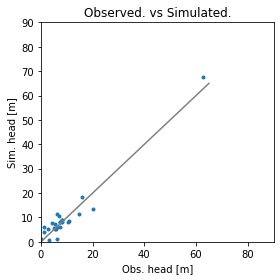

Error is - 2.965233395823309
Params are - [6.97649393e-01 1.14692674e+01 1.20308639e+01 4.23516850e-01
 1.68287545e+00 4.41283739e-01 1.73821824e-03 8.31826046e-01
 2.91670723e-01 3.26714728e-01 1.36649902e-03 2.60394319e+00]


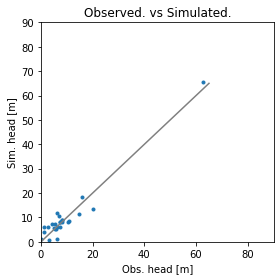

Error is - 2.873263450137038
Params are - [7.09940551e-01 9.27330891e+00 1.23941899e+01 4.21960663e-01
 1.68042800e+00 4.44015320e-01 1.84602292e-03 8.65253109e-01
 2.88127227e-01 3.20757970e-01 1.28871948e-03 2.62901984e+00]


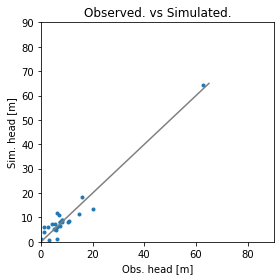

Error is - 2.860064191729948
Params are - [7.16729666e-01 1.01088671e+01 1.20829146e+01 4.23827877e-01
 1.61877268e+00 4.45531369e-01 1.91157543e-03 8.34777348e-01
 2.75316133e-01 3.26319709e-01 1.33649724e-03 2.89707366e+00]


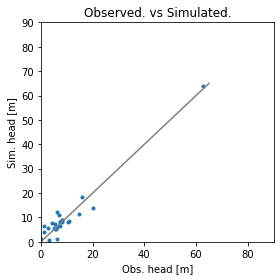

Error is - 2.861306398869776
Params are - [7.09245618e-01 1.11310428e+01 1.23598650e+01 4.18232688e-01
 1.57974661e+00 4.42557067e-01 1.94814746e-03 8.22752823e-01
 2.67668838e-01 3.20926037e-01 1.47725251e-03 2.67096741e+00]


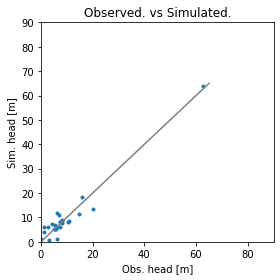

Error is - 2.843109856031181
Params are - [7.45680191e-01 9.21231403e+00 1.21603581e+01 4.45208260e-01
 1.63232771e+00 4.60930674e-01 1.92670016e-03 8.74242493e-01
 2.79638403e-01 3.35849951e-01 1.28878925e-03 2.62853968e+00]


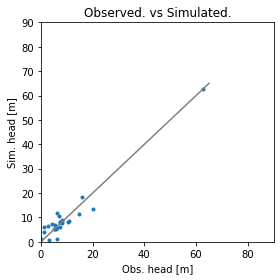

Error is - 2.8278318527795485
Params are - [7.74441775e-01 7.98578065e+00 1.16646293e+01 4.60334004e-01
 1.67499400e+00 4.70716116e-01 1.97531473e-03 9.20034853e-01
 2.86428858e-01 3.45324606e-01 1.20589690e-03 2.46477483e+00]


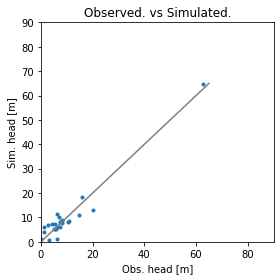

Error is - 2.8576730459221795
Params are - [7.03683663e-01 7.71939437e+00 1.14087888e+01 4.16327270e-01
 1.77487558e+00 4.37868484e-01 1.85223566e-03 9.05044763e-01
 3.00574722e-01 3.45496696e-01 1.25599098e-03 2.41552155e+00]


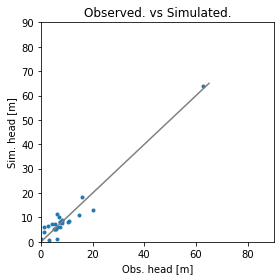

Error is - 2.8201692322655747
Params are - [7.38970765e-01 8.54623722e+00 1.14695010e+01 4.12381086e-01
 1.77373103e+00 4.33763939e-01 1.88388679e-03 8.49698224e-01
 2.96747896e-01 3.42650540e-01 1.21792660e-03 2.40586211e+00]


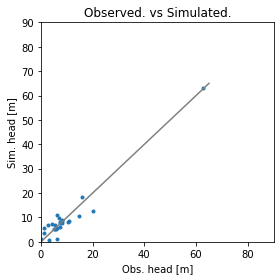

Error is - 2.8321711135381955
Params are - [7.57681599e-01 7.29974499e+00 1.05938307e+01 3.95916589e-01
 1.91485915e+00 4.18187151e-01 1.88674989e-03 8.53660854e-01
 3.14431179e-01 3.54066592e-01 1.10065090e-03 2.11705697e+00]


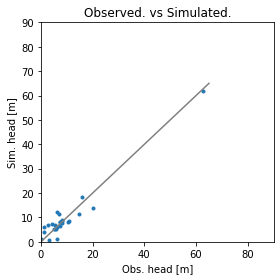

Error is - 2.91060178795873
Params are - [7.49757366e-01 7.62901980e+00 1.25659185e+01 4.32318357e-01
 1.59747297e+00 4.56144418e-01 2.04810725e-03 8.62623839e-01
 2.67304698e-01 3.38410215e-01 1.27914352e-03 2.75237779e+00]


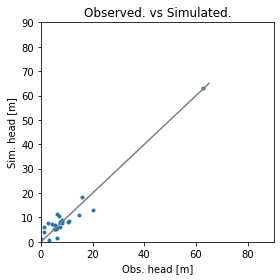

Error is - 2.884303386556283
Params are - [7.57836960e-01 5.63690715e+00 1.14447310e+01 4.12480972e-01
 1.75674296e+00 4.29516877e-01 1.93100929e-03 9.07780104e-01
 3.05888055e-01 3.41537149e-01 1.26718754e-03 2.41799940e+00]


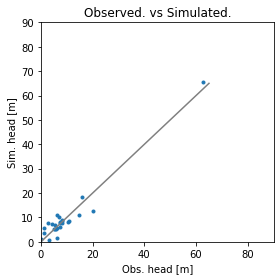

Error is - 2.931156042364701
Params are - [7.50714796e-01 5.81145475e+00 1.04711304e+01 4.04913037e-01
 1.90071975e+00 4.28860751e-01 1.78751431e-03 9.40138277e-01
 3.18060142e-01 3.47489731e-01 1.17175966e-03 2.17213934e+00]


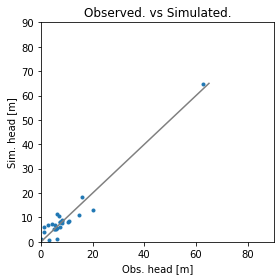

Error is - 2.8691422343345825
Params are - [7.41235314e-01 7.22854591e+00 1.12710707e+01 4.14704587e-01
 1.78617660e+00 4.37032543e-01 1.84381880e-03 9.01487752e-01
 3.01529607e-01 3.41333490e-01 1.23686834e-03 2.39209411e+00]


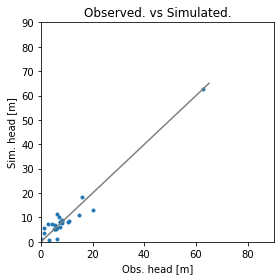

Error is - 2.8545535498965893
Params are - [7.44702064e-01 6.56081914e+00 1.14255182e+01 3.97115625e-01
 1.84054270e+00 4.23227773e-01 1.93371552e-03 9.23618220e-01
 3.02899907e-01 3.42316504e-01 1.20121171e-03 2.36932257e+00]


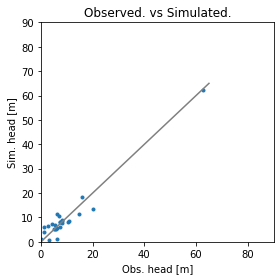

Error is - 2.801066293025864
Params are - [7.46852406e-01 8.68938784e+00 1.13707104e+01 4.09600726e-01
 1.67163805e+00 4.35774361e-01 1.98408085e-03 9.16007368e-01
 2.94461265e-01 3.41172680e-01 1.23515099e-03 2.44388014e+00]


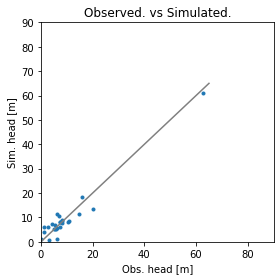

Error is - 2.793365426883306
Params are - [7.58572919e-01 9.09333171e+00 1.08550336e+01 4.00000864e-01
 1.64222315e+00 4.30433528e-01 2.06103255e-03 9.54950499e-01
 2.99860913e-01 3.45415909e-01 1.19045132e-03 2.33338847e+00]


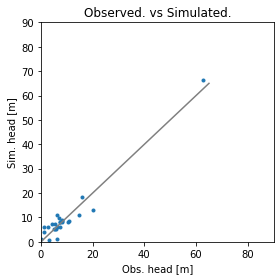

Error is - 2.8721405960613637
Params are - [7.21975678e-01 9.18592012e+00 1.09217082e+01 4.00696570e-01
 1.81209129e+00 4.21800820e-01 1.76830528e-03 9.06892412e-01
 3.16244572e-01 3.36616301e-01 1.26577577e-03 2.28653429e+00]


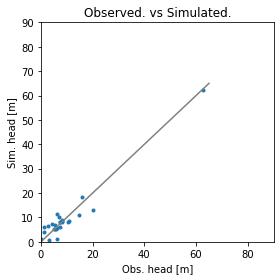

Error is - 2.811901271397972
Params are - [7.40899112e-01 7.79183606e+00 1.08587070e+01 4.24920927e-01
 1.78912625e+00 4.10767189e-01 1.96217361e-03 9.28238513e-01
 3.02178594e-01 3.39244795e-01 1.22603427e-03 2.31678893e+00]


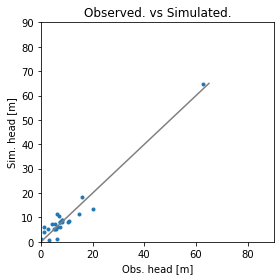

Error is - 2.8120060858068574
Params are - [7.09807644e-01 1.15604471e+01 1.17013377e+01 4.21550506e-01
 1.68559756e+00 4.38820952e-01 1.87832106e-03 8.74519407e-01
 2.82024957e-01 3.33226533e-01 1.26328583e-03 2.54181728e+00]


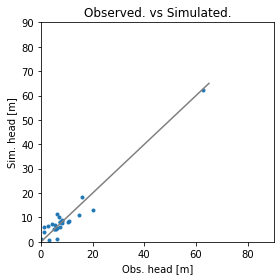

Error is - 2.7975646599532356
Params are - [7.57681902e-01 8.30523499e+00 1.06364035e+01 4.12002456e-01
 1.76277412e+00 4.23456781e-01 1.96869045e-03 9.18590785e-01
 2.98768740e-01 3.56083806e-01 1.23751496e-03 2.31626308e+00]


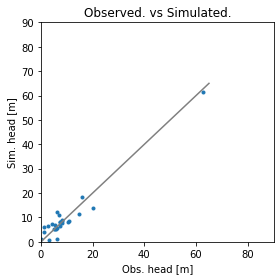

Error is - 2.8883677282287348
Params are - [7.51597813e-01 8.24584292e+00 1.20613343e+01 4.35150862e-01
 1.62289130e+00 4.45947274e-01 2.07980562e-03 8.78901210e-01
 2.67738756e-01 3.43470060e-01 1.25574853e-03 2.66370344e+00]


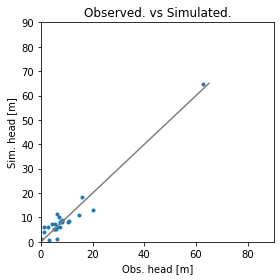

Error is - 2.8222674409491137
Params are - [7.29381212e-01 8.95090082e+00 1.12066148e+01 4.09310143e-01
 1.76479129e+00 4.27837434e-01 1.84618036e-03 8.99894612e-01
 3.04118118e-01 3.38329740e-01 1.26326896e-03 2.38082657e+00]


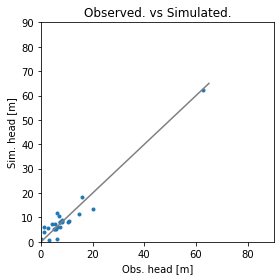

Error is - 2.7941229746463745
Params are - [7.30362493e-01 1.04902763e+01 1.17012292e+01 4.20243771e-01
 1.64524177e+00 4.29183033e-01 2.00468570e-03 8.84040348e-01
 2.82885139e-01 3.38252246e-01 1.28905606e-03 2.55626569e+00]


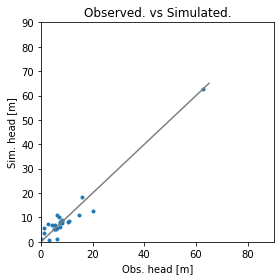

Error is - 2.835292377465044
Params are - [7.65871668e-01 6.48098501e+00 1.05026623e+01 4.17050851e-01
 1.86258761e+00 4.21429503e-01 1.90978008e-03 9.72989864e-01
 3.19281959e-01 3.61547400e-01 1.01730581e-03 2.25827544e+00]


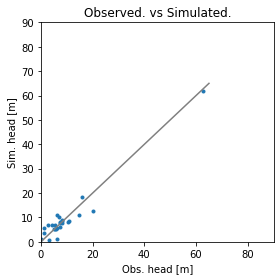

Error is - 2.821536244877548
Params are - [7.66577953e-01 6.89851363e+00 1.05162373e+01 4.10326158e-01
 1.86419736e+00 4.14438224e-01 1.94605288e-03 9.84000758e-01
 3.18962301e-01 3.62025010e-01 1.10486252e-03 1.92570282e+00]


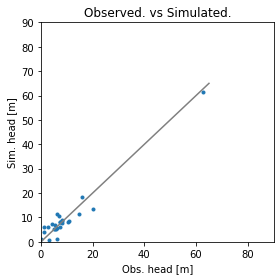

Error is - 2.7763412735263917
Params are - [7.90106339e-01 9.15117293e+00 1.10416045e+01 4.16826579e-01
 1.72298144e+00 4.18196065e-01 2.02102886e-03 9.26892676e-01
 2.96768309e-01 3.45602743e-01 1.16018070e-03 2.32561847e+00]


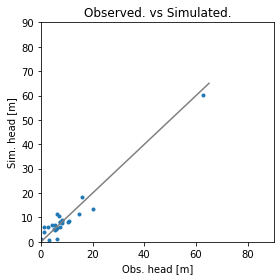

Error is - 2.789869387310383
Params are - [8.33317676e-01 9.86706222e+00 1.08580123e+01 4.17076233e-01
 1.69703437e+00 4.08359855e-01 2.10542546e-03 9.37816632e-01
 2.94865103e-01 3.45655766e-01 1.11227556e-03 2.28066694e+00]


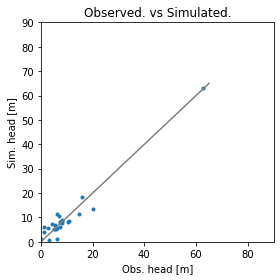

Error is - 2.764925582293872
Params are - [7.56655317e-01 1.07414738e+01 1.09608894e+01 4.39323383e-01
 1.63772077e+00 4.31998159e-01 1.95410121e-03 9.08864961e-01
 2.93421191e-01 3.49330640e-01 1.20812147e-03 2.36453344e+00]


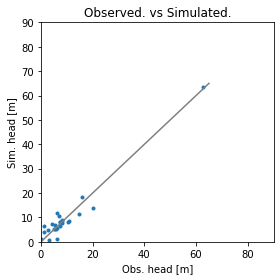

Error is - 2.7638338234506263
Params are - [7.62631943e-01 1.28318011e+01 1.07285750e+01 4.60427262e-01
 1.53630981e+00 4.36383352e-01 1.96429405e-03 9.01488331e-01
 2.88681832e-01 3.52837708e-01 1.21157635e-03 2.36213887e+00]


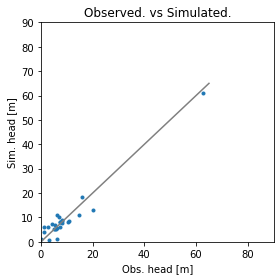

Error is - 2.7752760191050854
Params are - [7.58747120e-01 9.45537833e+00 9.98260351e+00 4.30542397e-01
 1.77275734e+00 4.46924862e-01 2.03382019e-03 9.54841263e-01
 3.06217132e-01 3.51243967e-01 1.11767825e-03 2.12040142e+00]


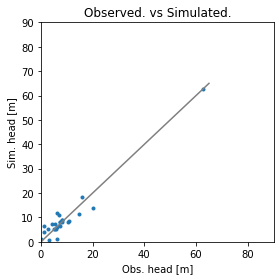

Error is - 2.8016922758829597
Params are - [7.37158528e-01 1.20291668e+01 1.15577505e+01 4.29426842e-01
 1.57653324e+00 4.42057409e-01 2.01446680e-03 8.59875181e-01
 2.74658506e-01 3.30158867e-01 1.39731631e-03 2.41669931e+00]


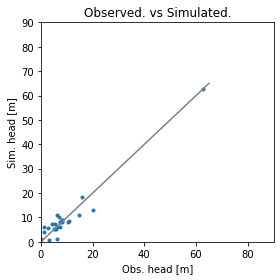

Error is - 2.741705506449527
Params are - [7.22374546e-01 1.11982688e+01 1.03779703e+01 3.80992494e-01
 1.74771673e+00 3.87994346e-01 1.95545748e-03 9.02803579e-01
 3.05549882e-01 3.43854038e-01 1.24062845e-03 2.20218734e+00]


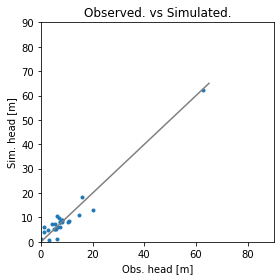

Error is - 2.7283394661868057
Params are - [6.96340931e-01 1.28045129e+01 9.73464075e+00 3.41321740e-01
 1.78407809e+00 3.46633461e-01 1.94552886e-03 8.94187943e-01
 3.15110394e-01 3.43118754e-01 1.25799423e-03 2.07089359e+00]


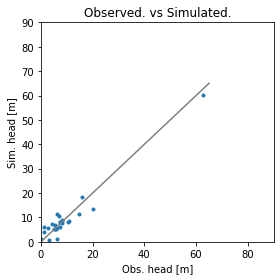

Error is - 2.7871547047436827
Params are - [7.61928396e-01 1.08754174e+01 1.05906558e+01 4.20684955e-01
 1.66113390e+00 4.17339032e-01 2.10114994e-03 9.21992709e-01
 2.89692667e-01 3.51647073e-01 1.18237727e-03 2.23448010e+00]


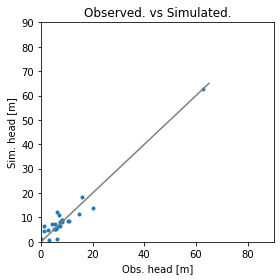

Error is - 2.811683106915231
Params are - [7.23956729e-01 1.35906218e+01 1.12934364e+01 4.21395406e-01
 1.52788392e+00 4.31221710e-01 2.02712693e-03 8.27551888e-01
 2.69970212e-01 3.26222147e-01 1.35370284e-03 2.74106674e+00]


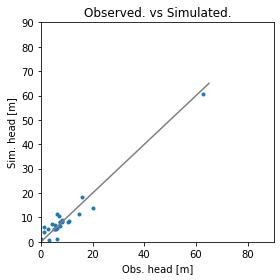

Error is - 2.7758716789206868
Params are - [7.49061577e-01 1.27836290e+01 1.03108286e+01 4.20842864e-01
 1.57737573e+00 4.11472290e-01 2.11316637e-03 9.58163366e-01
 2.87721670e-01 3.42858552e-01 1.26326813e-03 2.31677489e+00]


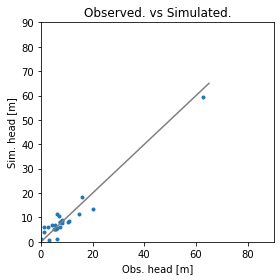

Error is - 2.815215900318084
Params are - [7.84767021e-01 9.97328283e+00 9.84724033e+00 4.11555504e-01
 1.64747223e+00 4.01857167e-01 2.15787299e-03 9.47282843e-01
 3.03394061e-01 3.53887894e-01 1.21790595e-03 2.14331265e+00]


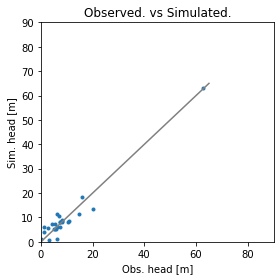

Error is - 2.7725876241998764
Params are - [7.28547488e-01 1.11636560e+01 1.12378134e+01 4.19051756e-01
 1.67606623e+00 4.29580005e-01 1.94820904e-03 8.92710266e-01
 2.87367233e-01 3.38391874e-01 1.25194086e-03 2.44219112e+00]


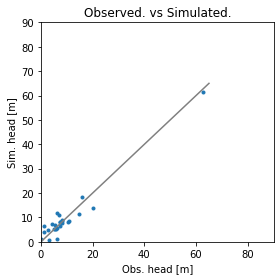

Error is - 2.7681790141718152
Params are - [7.51616948e-01 1.43038638e+01 1.07530554e+01 4.07206888e-01
 1.52510020e+00 4.33046399e-01 2.07169301e-03 8.87642363e-01
 2.80771864e-01 3.47727479e-01 1.25947528e-03 2.38924136e+00]


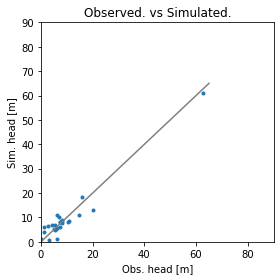

Error is - 2.778180631506249
Params are - [7.73169369e-01 8.62395172e+00 1.02282625e+01 4.08367656e-01
 1.78587858e+00 4.12895993e-01 2.01416738e-03 9.98344067e-01
 3.14780521e-01 3.64334349e-01 1.11610211e-03 1.90632599e+00]


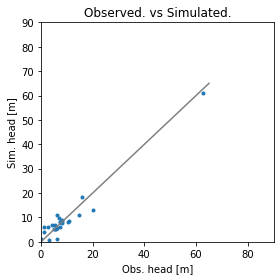

Error is - 2.760897279545086
Params are - [7.65969377e-01 9.61787091e+00 9.74236716e+00 3.96826356e-01
 1.77212015e+00 3.97200057e-01 2.02677760e-03 9.89098922e-01
 3.16779230e-01 3.66093543e-01 1.02561961e-03 2.14563120e+00]


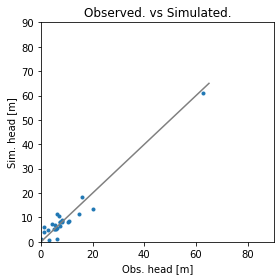

Error is - 2.7431501155611997
Params are - [7.46827248e-01 1.35605754e+01 1.05147081e+01 4.11721392e-01
 1.58743695e+00 4.11424565e-01 2.08223514e-03 9.42134674e-01
 2.95670744e-01 3.41836893e-01 1.15010507e-03 2.21762878e+00]


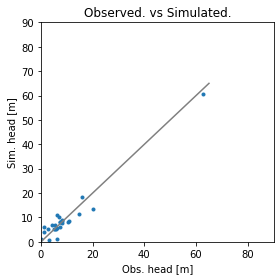

Error is - 2.7225533062348997
Params are - [7.76890783e-01 1.18872506e+01 9.25212890e+00 4.02059680e-01
 1.69533516e+00 4.02738568e-01 2.05916480e-03 9.86367499e-01
 3.13685279e-01 3.60265894e-01 1.07540547e-03 1.92118668e+00]


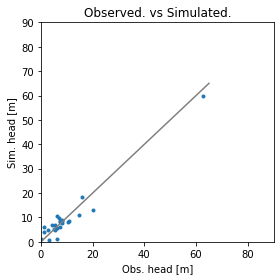

Error is - 2.72600542922796
Params are - [8.00154928e-01 1.25857377e+01 8.02757877e+00 3.92967634e-01
 1.72038185e+00 3.89516336e-01 2.08640436e-03 1.03753107e+00
 3.29085349e-01 3.71272719e-01 9.68580171e-04 1.60364718e+00]


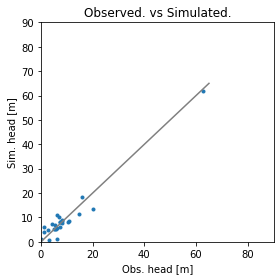

Error is - 2.707252081390257
Params are - [7.51733335e-01 1.37498483e+01 9.83117362e+00 4.22645724e-01
 1.70720578e+00 3.96872247e-01 2.00250666e-03 9.20693514e-01
 2.99013566e-01 3.55577229e-01 1.15483590e-03 2.07536361e+00]


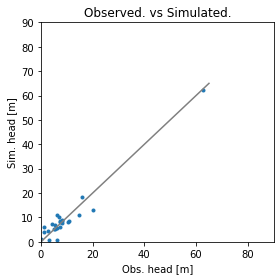

Error is - 2.693811786038172
Params are - [7.48313543e-01 1.60781066e+01 9.31924361e+00 4.33968154e-01
 1.73969710e+00 3.80091606e-01 1.97324371e-03 9.03565021e-01
 2.98589893e-01 3.60657890e-01 1.13702820e-03 1.94635118e+00]


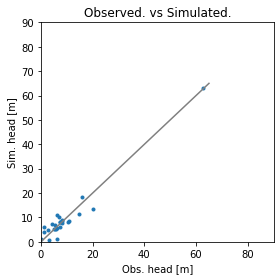

Error is - 2.7043425922649638
Params are - [7.46108715e-01 1.28348775e+01 9.88364938e+00 4.04175499e-01
 1.70138890e+00 4.03758838e-01 1.94107156e-03 9.50580022e-01
 3.10664683e-01 3.50847868e-01 1.15535177e-03 2.12625049e+00]


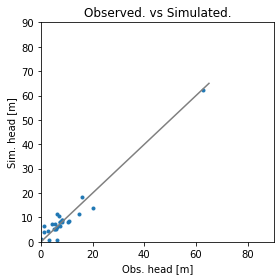

Error is - 2.745013643479513
Params are - [7.30357633e-01 1.57881641e+01 1.01886072e+01 4.15794105e-01
 1.56256260e+00 4.06679018e-01 2.01587149e-03 8.66267991e-01
 2.84890856e-01 3.35912845e-01 1.22816854e-03 2.49105868e+00]


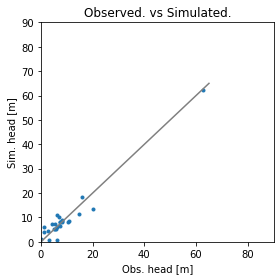

Error is - 2.7064235929409866
Params are - [7.03462546e-01 1.63671081e+01 9.23309901e+00 4.07163103e-01
 1.59872327e+00 3.99459439e-01 2.00815045e-03 9.27615268e-01
 3.00923492e-01 3.53029469e-01 1.19542126e-03 2.09933957e+00]


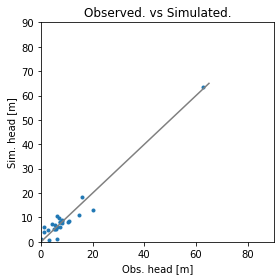

Error is - 2.7147726471839344
Params are - [7.36907468e-01 1.33318986e+01 9.78425335e+00 4.00866858e-01
 1.74788690e+00 4.04181072e-01 1.89851028e-03 8.91253228e-01
 3.12170436e-01 3.57468812e-01 1.08102602e-03 2.07194394e+00]


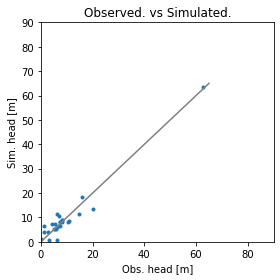

Error is - 2.7273213247076082
Params are - [7.23581984e-01 1.73062360e+01 1.00794200e+01 3.86221402e-01
 1.54836022e+00 3.61604535e-01 1.95530481e-03 8.83977324e-01
 2.94667191e-01 3.50120871e-01 1.22050719e-03 2.26024116e+00]


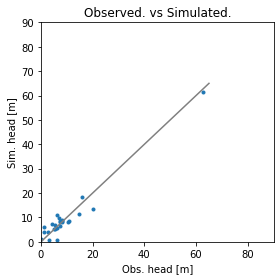

Error is - 2.680351105177633
Params are - [7.52954032e-01 1.66217216e+01 8.63114460e+00 3.92240317e-01
 1.62376700e+00 3.67620146e-01 2.04209859e-03 9.44652831e-01
 3.14733749e-01 3.64927798e-01 1.08100563e-03 1.90812646e+00]


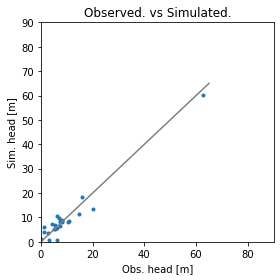

Error is - 2.675422615090226
Params are - [7.65157303e-01 1.93507544e+01 7.32781021e+00 3.78834598e-01
 1.59761738e+00 3.36640216e-01 2.08904336e-03 9.70624114e-01
 3.28417008e-01 3.78195760e-01 9.95538020e-04 1.64109413e+00]


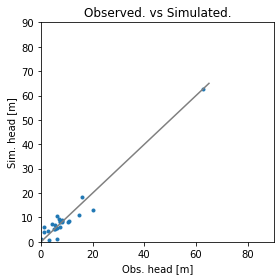

Error is - 2.6915973654940353
Params are - [7.32141297e-01 1.43226622e+01 8.54502838e+00 3.99356470e-01
 1.78681922e+00 3.48086056e-01 1.92150634e-03 9.63551026e-01
 3.29269976e-01 3.60670239e-01 1.02948167e-03 1.83638502e+00]


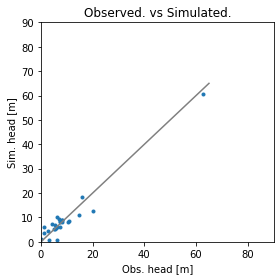

Error is - 2.715890660331654
Params are - [7.16044529e-01 1.60432018e+01 8.20558432e+00 3.35957631e-01
 1.81736118e+00 3.30032887e-01 2.02177401e-03 9.60048841e-01
 3.28124698e-01 3.56865432e-01 1.04703149e-03 1.77586187e+00]


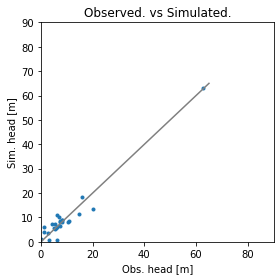

Error is - 2.702465166698027
Params are - [7.04386287e-01 2.03280205e+01 8.93566171e+00 3.89413749e-01
 1.58909101e+00 3.58021653e-01 1.95845653e-03 8.67596570e-01
 3.01918212e-01 3.42071578e-01 1.23655688e-03 1.93074132e+00]


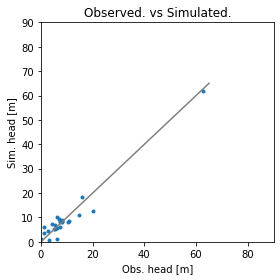

Error is - 2.688724564064807
Params are - [7.35669472e-01 1.49143699e+01 8.28059744e+00 3.66049274e-01
 1.80306997e+00 3.40433131e-01 1.95979348e-03 9.90648931e-01
 3.36644478e-01 3.73278732e-01 1.03540600e-03 1.49192761e+00]


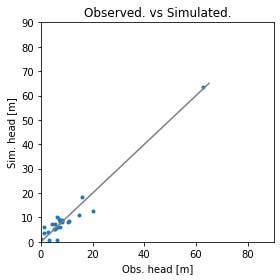

Error is - 2.696615521696515
Params are - [7.17340228e-01 1.73675912e+01 7.58214477e+00 3.62509967e-01
 1.81413445e+00 3.23855678e-01 1.87302289e-03 9.22867957e-01
 3.32693546e-01 3.72594990e-01 1.09435296e-03 1.64440731e+00]


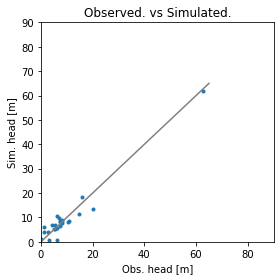

Error is - 2.652996812754504
Params are - [7.71326428e-01 1.88841666e+01 8.00346276e+00 4.36440991e-01
 1.62250270e+00 3.84850486e-01 1.99764485e-03 9.75594691e-01
 3.16184421e-01 3.76225835e-01 9.59190262e-04 1.72006146e+00]


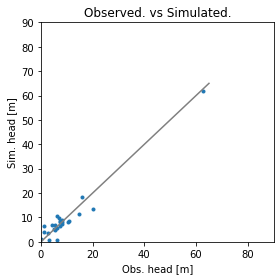

Error is - 2.646552109618644
Params are - [8.08819176e-01 2.19239935e+01 7.13787377e+00 4.84000617e-01
 1.54171500e+00 4.03958998e-01 2.02370284e-03 1.01629807e+00
 3.16721435e-01 3.92779375e-01 8.09788280e-04 1.54464539e+00]


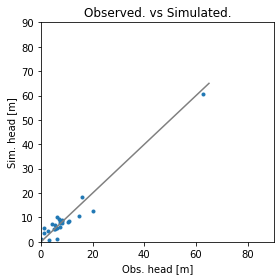

Error is - 2.710404360366102
Params are - [7.58291574e-01 1.51520699e+01 7.16842578e+00 4.07837865e-01
 1.85711303e+00 3.76938489e-01 1.99926857e-03 1.00785877e+00
 3.40303331e-01 3.76333468e-01 9.28224147e-04 1.41144793e+00]


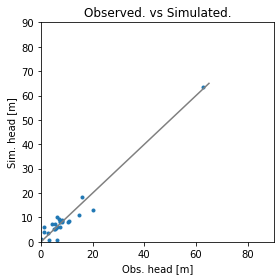

Error is - 2.6809001064603475
Params are - [7.01882907e-01 2.11151918e+01 7.64843306e+00 3.92962618e-01
 1.73710108e+00 3.31504442e-01 1.88542587e-03 9.09050469e-01
 3.25721586e-01 3.68866374e-01 1.04879565e-03 1.66554594e+00]


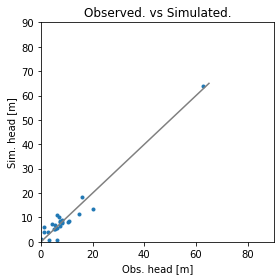

Error is - 2.6890363880811496
Params are - [7.60368891e-01 1.78045722e+01 8.60211909e+00 4.68565498e-01
 1.60169837e+00 4.04455383e-01 1.90009197e-03 9.26869398e-01
 3.10881648e-01 3.74266994e-01 1.07746365e-03 1.79248477e+00]


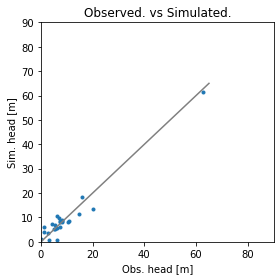

Error is - 2.6522479355473108
Params are - [7.43416188e-01 2.12613211e+01 6.82642769e+00 4.14939378e-01
 1.64680790e+00 3.30352916e-01 2.02361932e-03 1.00160104e+00
 3.26621112e-01 3.76463311e-01 1.04287540e-03 1.44982617e+00]


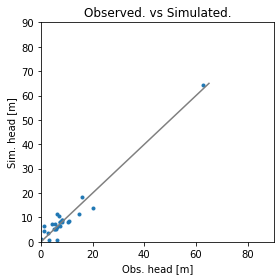

Error is - 2.7341299984051126
Params are - [7.19552852e-01 2.04593583e+01 9.38525557e+00 4.09151956e-01
 1.50253091e+00 3.49831237e-01 1.92691948e-03 8.83952548e-01
 2.96207847e-01 3.57620295e-01 1.21478581e-03 2.11671856e+00]


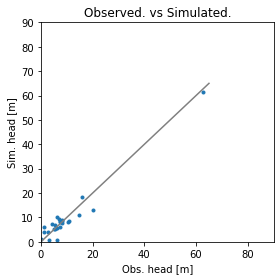

Error is - 2.677325640853129
Params are - [7.48606893e-01 1.64788920e+01 7.72263323e+00 4.08166388e-01
 1.76846750e+00 3.70161676e-01 1.98118130e-03 9.76882212e-01
 3.29279460e-01 3.71655175e-01 9.99864563e-04 1.58776558e+00]


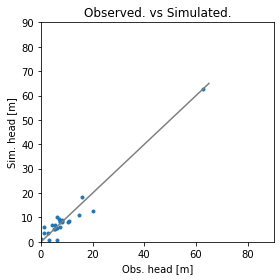

Error is - 2.6603323520527002
Params are - [7.81905938e-01 1.92629507e+01 7.06883804e+00 4.09993932e-01
 1.78921137e+00 3.22427327e-01 1.91354275e-03 9.72407203e-01
 3.40313680e-01 3.84028579e-01 9.14995913e-04 1.34356458e+00]


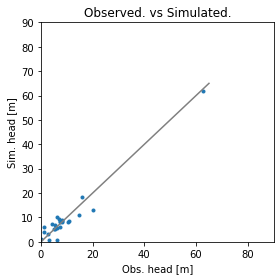

Error is - 2.652129370693299
Params are - [7.45225973e-01 2.38665268e+01 5.94915245e+00 4.13951275e-01
 1.70118283e+00 3.04572676e-01 1.97603350e-03 9.53080313e-01
 3.35513989e-01 3.91740298e-01 9.15006091e-04 1.18620601e+00]


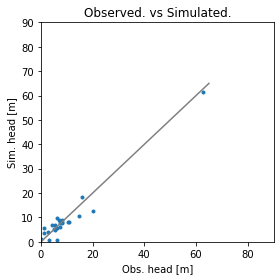

Error is - 2.6813318589671344
Params are - [7.93755015e-01 1.69631349e+01 6.39938857e+00 4.32802612e-01
 1.83216268e+00 3.41401698e-01 1.96157802e-03 1.05031106e+00
 3.49859757e-01 4.08794708e-01 7.80209190e-04 1.25762596e+00]


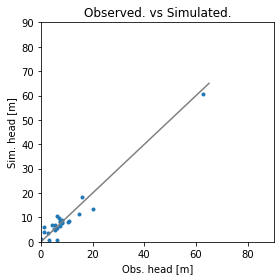

Error is - 2.6560589787228706
Params are - [7.93536871e-01 1.98561549e+01 7.55577948e+00 4.71421835e-01
 1.61012395e+00 3.78492009e-01 2.06177085e-03 1.01628018e+00
 3.21945458e-01 3.84304582e-01 8.70055811e-04 1.47949641e+00]


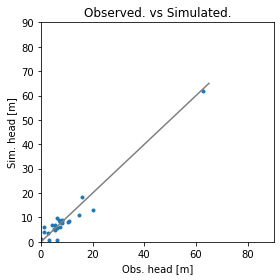

Error is - 2.636515525224168
Params are - [7.70100778e-01 2.17753141e+01 5.52476995e+00 4.06205929e-01
 1.66296577e+00 3.21989483e-01 1.97630456e-03 1.05436898e+00
 3.59941705e-01 4.00182798e-01 7.82885178e-04 1.09974342e+00]


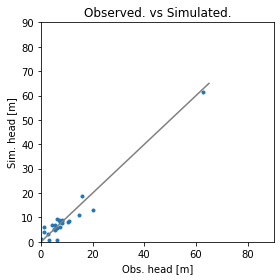

Error is - 2.6448108397311
Params are - [7.80994396e-01 2.46239179e+01 3.62753312e+00 3.92324816e-01
 1.62460011e+00 2.92938421e-01 1.97783498e-03 1.12977096e+00
 3.90617611e-01 4.19945252e-01 6.05813669e-04 6.76439535e-01]


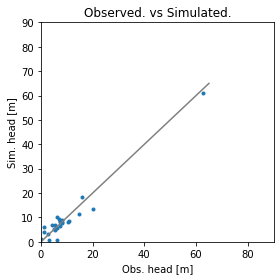

Error is - 2.637339020795195
Params are - [7.92599603e-01 2.47728672e+01 5.79560878e+00 4.41959188e-01
 1.59520141e+00 3.49645603e-01 2.03717496e-03 1.00951930e+00
 3.34373577e-01 4.06755875e-01 8.49332283e-04 1.08693598e+00]


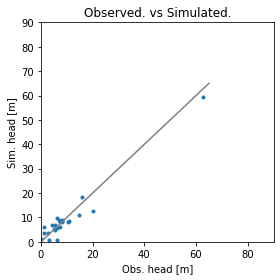

Error is - 2.726352420241019
Params are - [7.69743795e-01 2.24523396e+01 5.27076636e+00 3.68315776e-01
 1.77923944e+00 2.84141313e-01 2.08143650e-03 1.05997591e+00
 3.56677227e-01 3.98573933e-01 7.63328413e-04 1.01324476e+00]


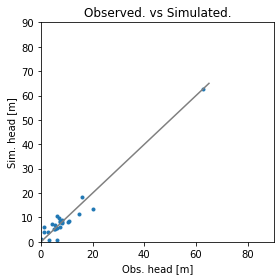

Error is - 2.649001840171169
Params are - [7.62712617e-01 1.89665141e+01 7.76928090e+00 4.43503067e-01
 1.64608364e+00 3.74376865e-01 1.94542810e-03 9.60146027e-01
 3.22330543e-01 3.80343729e-01 9.98929841e-04 1.59767477e+00]


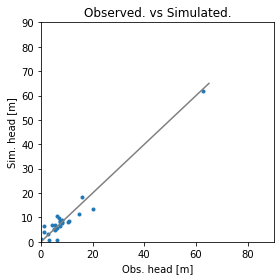

Error is - 2.6354954740975813
Params are - [7.98950404e-01 2.60178993e+01 5.50706859e+00 4.83740965e-01
 1.55170345e+00 3.53820854e-01 2.01934075e-03 9.91112563e-01
 3.28528740e-01 4.00739695e-01 7.99306700e-04 1.33142645e+00]


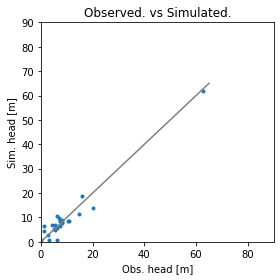

Error is - 2.6584803536899275
Params are - [8.30590871e-01 3.15696639e+01 4.12030416e+00 5.42586811e-01
 1.42602020e+00 3.60514716e-01 2.04911439e-03 9.91344380e-01
 3.24470871e-01 4.14470177e-01 6.81257050e-04 1.25117588e+00]


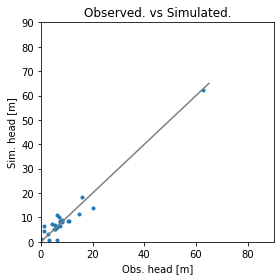

Error is - 2.676559599343332
Params are - [7.41730761e-01 2.54782617e+01 7.23955745e+00 4.25477353e-01
 1.47586753e+00 3.54922146e-01 2.02718334e-03 9.21584024e-01
 3.11758292e-01 3.63881217e-01 1.05768643e-03 1.57802818e+00]


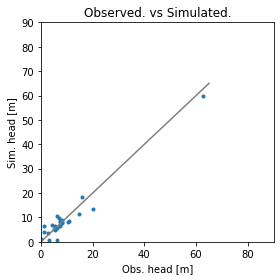

Error is - 2.6730444050104416
Params are - [8.40244178e-01 2.20533832e+01 5.92236703e+00 4.70736470e-01
 1.52739021e+00 3.68722353e-01 2.12696173e-03 1.06493354e+00
 3.33569248e-01 4.02978691e-01 7.90581771e-04 1.15552190e+00]


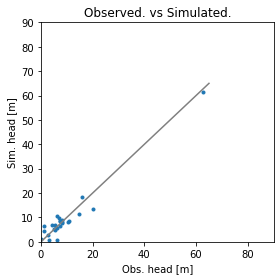

Error is - 2.64532322308717
Params are - [8.08793072e-01 2.76187648e+01 5.54812250e+00 4.65961046e-01
 1.45584424e+00 3.29825232e-01 2.05550304e-03 1.01177701e+00
 3.30726338e-01 4.05410477e-01 8.04632390e-04 1.16126165e+00]


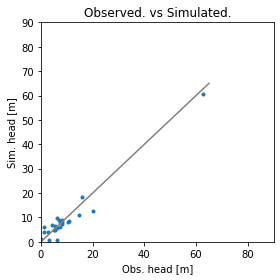

Error is - 2.6700807395904333
Params are - [8.26846256e-01 1.89761456e+01 5.74929245e+00 4.55397364e-01
 1.74510700e+00 3.40881942e-01 2.01422096e-03 1.08210737e+00
 3.51408847e-01 4.20105977e-01 7.04634849e-04 1.10153796e+00]


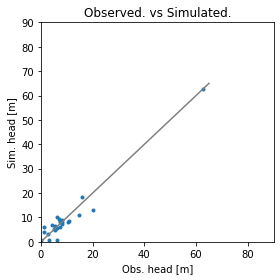

Error is - 2.6286954079377787
Params are - [8.13701206e-01 2.50412181e+01 5.39795340e+00 5.14800580e-01
 1.64793875e+00 3.59870827e-01 1.93989053e-03 1.05164782e+00
 3.38582104e-01 4.12776472e-01 7.18299397e-04 9.48545983e-01]


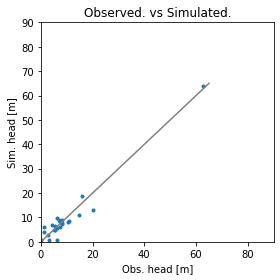

Error is - 2.655097923845293
Params are - [8.37973157e-01 2.78864500e+01 4.43302499e+00 5.82783570e-01
 1.67309943e+00 3.71486132e-01 1.86531412e-03 1.09215967e+00
 3.43664653e-01 4.30066828e-01 5.79680086e-04 6.02271907e-01]


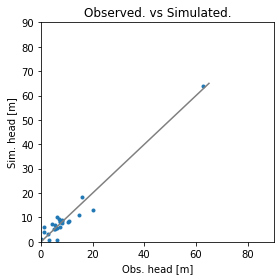

Error is - 2.669003084873908
Params are - [7.34190503e-01 2.28365618e+01 6.71599430e+00 4.30242726e-01
 1.73825734e+00 3.26313436e-01 1.87079363e-03 9.55124111e-01
 3.34265341e-01 3.89626503e-01 9.11208585e-04 1.39962223e+00]


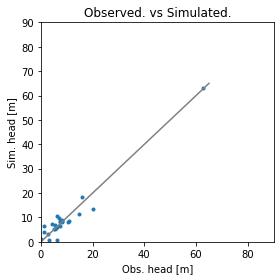

Error is - 2.671179733180945
Params are - [7.32145798e-01 2.65572021e+01 7.05018586e+00 4.41389392e-01
 1.51939894e+00 3.51725762e-01 1.95962985e-03 9.16786404e-01
 3.13568490e-01 3.67419305e-01 1.03158446e-03 1.50328687e+00]


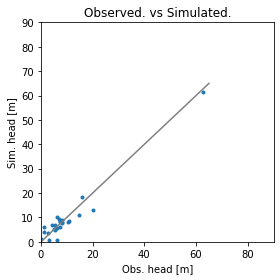

Error is - 2.6450909425895017
Params are - [8.03171142e-01 2.08714097e+01 6.07451580e+00 4.51895371e-01
 1.68867998e+00 3.43592897e-01 2.00057318e-03 1.04077713e+00
 3.41948758e-01 4.06934309e-01 7.86372252e-04 1.20197519e+00]


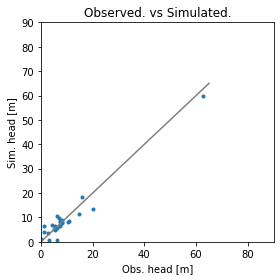

Error is - 2.671853731966069
Params are - [8.36298325e-01 2.23692605e+01 5.97657093e+00 4.70152804e-01
 1.51798571e+00 3.69174179e-01 2.12468710e-03 1.05804516e+00
 3.31992566e-01 4.00783413e-01 8.04204671e-04 1.17226144e+00]


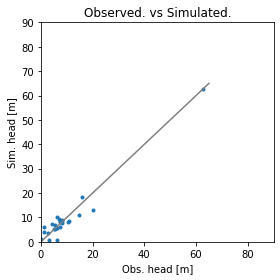

Error is - 2.6418748169959185
Params are - [7.59717458e-01 2.27197365e+01 6.53113845e+00 4.40220246e-01
 1.68318943e+00 3.37028622e-01 1.93426700e-03 9.80854374e-01
 3.33697147e-01 3.92415731e-01 8.84457606e-04 1.34278203e+00]


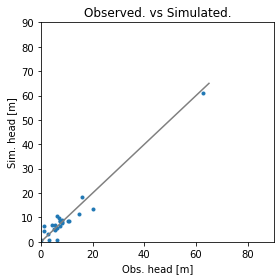

Error is - 2.663343316702879
Params are - [7.84884810e-01 2.65190027e+01 5.53411059e+00 4.95439318e-01
 1.44936136e+00 3.75493837e-01 2.08539202e-03 1.04216993e+00
 3.24841471e-01 4.07779196e-01 7.95327625e-04 1.22818866e+00]


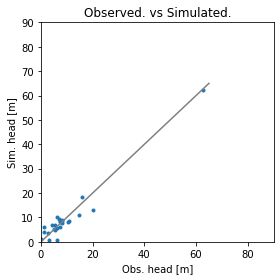

Error is - 2.6418934644718512
Params are - [7.82650656e-01 2.10769637e+01 6.68515618e+00 4.31355278e-01
 1.70424887e+00 3.35693954e-01 1.95650507e-03 9.89847885e-01
 3.36445628e-01 3.89966233e-01 8.85078841e-04 1.31472060e+00]


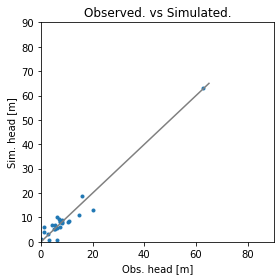

Error is - 2.6394597569832334
Params are - [7.71439508e-01 2.61292666e+01 4.90206526e+00 4.27333655e-01
 1.64413627e+00 3.12296145e-01 1.91961963e-03 9.93891567e-01
 3.45626388e-01 4.08446801e-01 8.42771566e-04 1.06479420e+00]


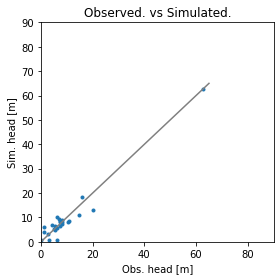

Error is - 2.6222497982151736
Params are - [8.26230744e-01 2.55354247e+01 5.31068999e+00 4.85881825e-01
 1.60700704e+00 3.57425777e-01 1.94043787e-03 1.00728580e+00
 3.44118280e-01 4.21618655e-01 6.36601341e-04 1.03029244e+00]


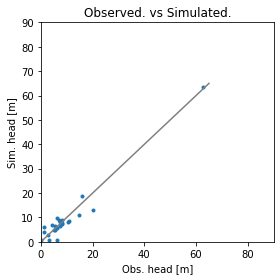

Error is - 2.629866280674992
Params are - [8.67638022e-01 2.76724765e+01 4.55282114e+00 5.21353049e-01
 1.58710662e+00 3.70962207e-01 1.89884715e-03 1.01012818e+00
 3.52866864e-01 4.44196327e-01 4.33464312e-04 8.20525576e-01]


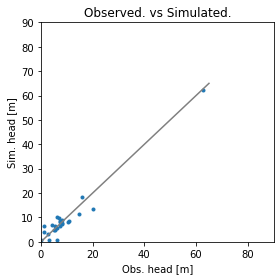

Error is - 2.620739685456701
Params are - [8.37921755e-01 2.32083686e+01 6.08155482e+00 4.98858353e-01
 1.53693615e+00 3.92014867e-01 1.98209109e-03 1.06484077e+00
 3.36659451e-01 4.11321394e-01 7.18069855e-04 1.26792701e+00]


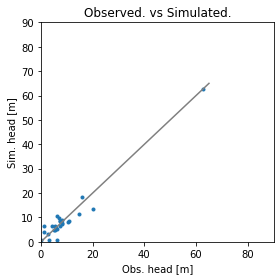

Error is - 2.6276328929563015
Params are - [8.84269646e-01 2.28792895e+01 6.14775600e+00 5.41311893e-01
 1.45481281e+00 4.35735963e-01 1.98511989e-03 1.12072101e+00
 3.37232182e-01 4.21111942e-01 6.19601736e-04 1.30878751e+00]


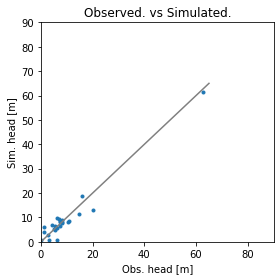

Error is - 2.629791605728971
Params are - [8.32969967e-01 2.88153570e+01 3.98013868e+00 4.78532442e-01
 1.57384409e+00 3.25150344e-01 2.01880699e-03 1.07522418e+00
 3.52231049e-01 4.27880907e-01 5.87336108e-04 8.01500289e-01]


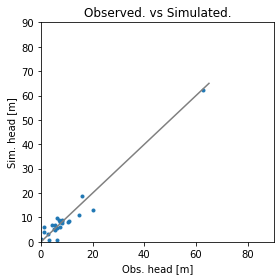

Error is - 2.6456097722239433
Params are - [7.90888539e-01 2.70064383e+01 4.08525663e+00 4.37123530e-01
 1.68356757e+00 2.82433436e-01 1.93971627e-03 1.02889317e+00
 3.63758426e-01 4.21295516e-01 7.39402306e-04 7.30672149e-01]


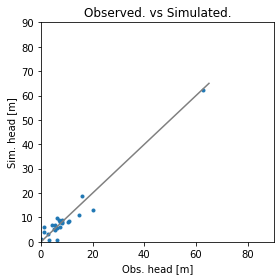

Error is - 2.6317789225314856
Params are - [7.95371199e-01 2.57358271e+01 4.84841091e+00 4.48842801e-01
 1.64810443e+00 3.12814826e-01 1.96071291e-03 1.02574439e+00
 3.51999178e-01 4.14166481e-01 7.56998799e-04 9.34165459e-01]


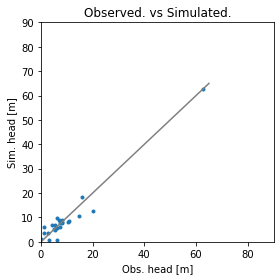

Error is - 2.66341979549042
Params are - [7.88677665e-01 2.09978439e+01 5.55838930e+00 4.52310059e-01
 1.80148170e+00 3.53732135e-01 1.89211771e-03 1.03574211e+00
 3.53298996e-01 4.10123749e-01 7.36619264e-04 1.07620653e+00]


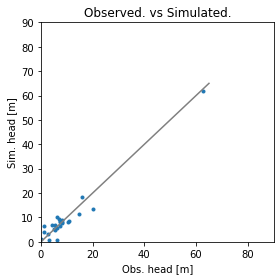

Error is - 2.627594278155466
Params are - [8.03764220e-01 2.59635346e+01 5.55068920e+00 4.62548300e-01
 1.54225361e+00 3.35801958e-01 2.01465671e-03 1.01776829e+00
 3.36369502e-01 4.06588795e-01 7.87629109e-04 1.13999787e+00]


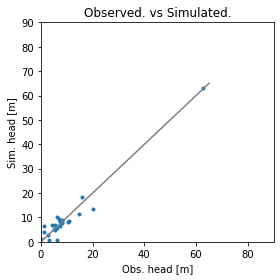

Error is - 2.6266381680366133
Params are - [7.94398441e-01 2.85938865e+01 4.94469157e+00 4.68151223e-01
 1.54424156e+00 3.38665979e-01 1.94939483e-03 1.00290720e+00
 3.41146700e-01 4.08542330e-01 7.55088878e-04 1.02516343e+00]


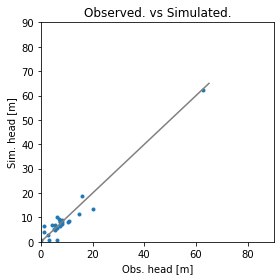

Error is - 2.6274883199569268
Params are - [8.16876891e-01 2.96411530e+01 4.04397375e+00 4.94823973e-01
 1.50200479e+00 3.47060260e-01 1.99227791e-03 1.05601299e+00
 3.47433342e-01 4.28606423e-01 6.34717296e-04 8.64158490e-01]


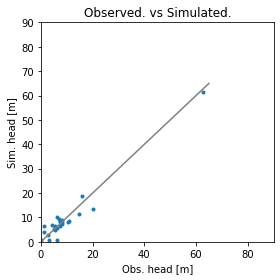

Error is - 2.6292464194393443
Params are - [8.49336661e-01 2.91519496e+01 3.78346403e+00 4.95059627e-01
 1.49286679e+00 3.47397532e-01 2.02418446e-03 1.07753293e+00
 3.52471189e-01 4.32188707e-01 5.93715145e-04 7.56326472e-01]


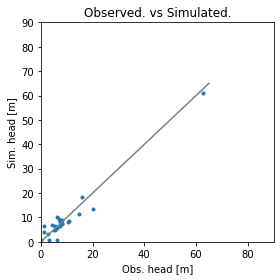

Error is - 2.630880664383855
Params are - [8.50597470e-01 2.62462000e+01 5.22610368e+00 5.19233879e-01
 1.50670838e+00 3.77980240e-01 2.05625930e-03 1.07843597e+00
 3.41682749e-01 4.20114620e-01 5.93891782e-04 9.82903019e-01]


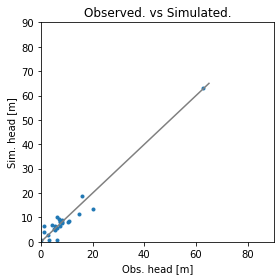

Error is - 2.6153622473181524
Params are - [8.39103686e-01 2.78481549e+01 4.23764264e+00 5.17487461e-01
 1.54089439e+00 3.45353221e-01 1.94188469e-03 1.07429435e+00
 3.54153755e-01 4.24032004e-01 5.44757648e-04 9.43422408e-01]


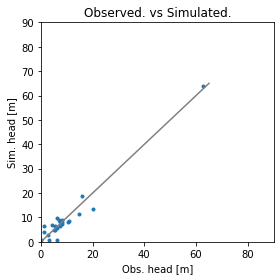

Error is - 2.6310853776722536
Params are - [8.62355727e-01 2.93857988e+01 3.45865957e+00 5.55251597e-01
 1.51374088e+00 3.43207030e-01 1.89423956e-03 1.10668187e+00
 3.64043843e-01 4.32670069e-01 3.92470330e-04 8.71665623e-01]


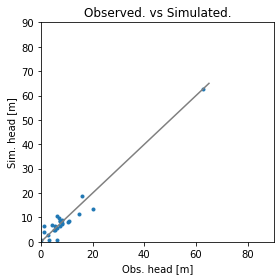

Error is - 2.640848300745545
Params are - [8.73102996e-01 3.18578481e+01 4.29396025e+00 5.71787643e-01
 1.45278480e+00 3.76903298e-01 1.99701845e-03 1.03276556e+00
 3.27620969e-01 4.34579949e-01 5.71516832e-04 9.04561470e-01]


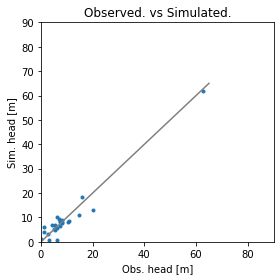

Error is - 2.623612733803031
Params are - [7.95851332e-01 2.42959476e+01 5.21706753e+00 4.47601357e-01
 1.61042053e+00 3.35717936e-01 1.98148303e-03 1.04896813e+00
 3.51861521e-01 4.08782086e-01 7.30043091e-04 1.05094793e+00]


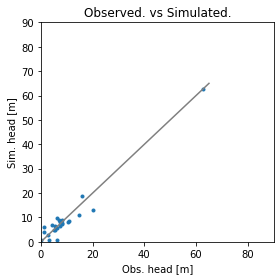

Error is - 2.6174472171505787
Params are - [8.43736857e-01 2.73282710e+01 4.26332811e+00 4.88229338e-01
 1.57383330e+00 3.42054774e-01 1.94767264e-03 1.10566457e+00
 3.62922730e-01 4.35363450e-01 5.43551374e-04 6.26132013e-01]


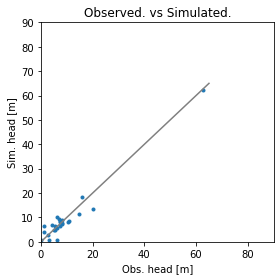

Error is - 2.6242528629449446
Params are - [8.55377007e-01 2.78757506e+01 4.82447198e+00 5.29691925e-01
 1.46505380e+00 3.87934126e-01 2.00412710e-03 1.08435278e+00
 3.41272884e-01 4.25469493e-01 5.50284705e-04 9.72054099e-01]


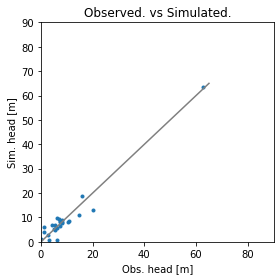

Error is - 2.6366166515430907
Params are - [8.00947324e-01 2.76369694e+01 4.37984060e+00 4.61043855e-01
 1.59950742e+00 3.24427694e-01 1.89989201e-03 1.03264733e+00
 3.51521003e-01 4.20413832e-01 7.06123875e-04 9.21508385e-01]


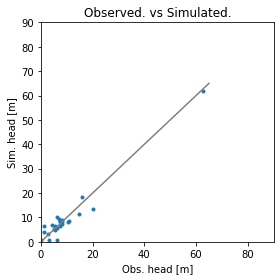

Error is - 2.6206627587242948
Params are - [8.38184934e-01 2.65938924e+01 5.01453791e+00 5.04686373e-01
 1.52990814e+00 3.64592103e-01 2.01716748e-03 1.06698881e+00
 3.44142312e-01 4.20189423e-01 6.21949806e-04 9.67554361e-01]


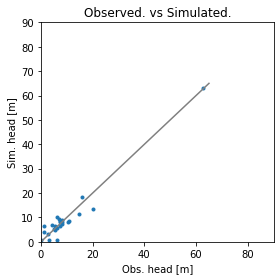

Error is - 2.626488232720055
Params are - [8.19443989e-01 2.46975682e+01 5.79820548e+00 5.06104281e-01
 1.52504905e+00 3.83831216e-01 1.93707107e-03 1.03448655e+00
 3.39624579e-01 4.11365632e-01 7.18448500e-04 1.13058679e+00]


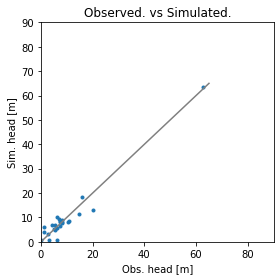

Error is - 2.627646509135135
Params are - [7.98095183e-01 2.36185788e+01 6.33067037e+00 4.91417871e-01
 1.61139006e+00 3.67656308e-01 1.91717470e-03 1.02500341e+00
 3.37243338e-01 4.03587319e-01 7.32858355e-04 1.23813733e+00]


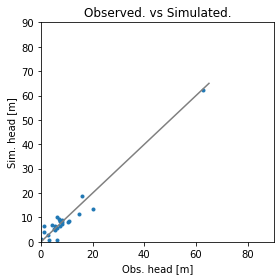

Error is - 2.62146693220862
Params are - [8.31129634e-01 2.74922037e+01 4.87163383e+00 4.67779800e-01
 1.45022666e+00 3.56480594e-01 1.99768265e-03 1.04644779e+00
 3.50909295e-01 4.21468029e-01 6.10700595e-04 1.09418305e+00]


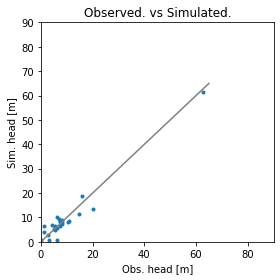

Error is - 2.632535773782397
Params are - [8.52241399e-01 2.95604472e+01 3.69574410e+00 4.87222830e-01
 1.45991478e+00 3.46832493e-01 2.03381648e-03 1.07666626e+00
 3.54525721e-01 4.33637300e-01 5.75782012e-04 7.80599315e-01]


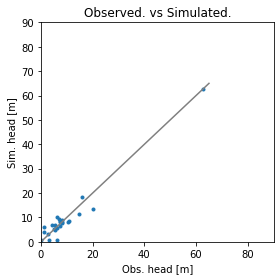

Error is - 2.6174312362228602
Params are - [8.11631737e-01 2.51040459e+01 5.67193880e+00 4.90369111e-01
 1.57352124e+00 3.62450355e-01 1.94633514e-03 1.03791912e+00
 3.41563933e-01 4.11099814e-01 6.93589269e-04 1.12375283e+00]


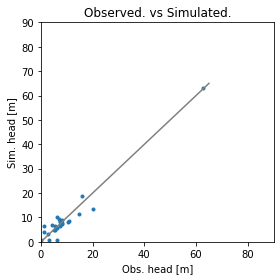

Error is - 2.6168890628516346
Params are - [8.47883614e-01 2.70722432e+01 4.49593354e+00 5.20729204e-01
 1.53426250e+00 3.83128244e-01 1.92494754e-03 1.08725985e+00
 3.56265295e-01 4.31387661e-01 5.05337951e-04 8.76031273e-01]


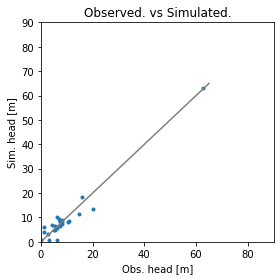

Error is - 2.6128510241269907
Params are - [8.39938730e-01 2.29664732e+01 6.07797561e+00 4.92771069e-01
 1.57988760e+00 3.77881272e-01 1.93610462e-03 1.05422296e+00
 3.46673447e-01 4.09833573e-01 6.36686540e-04 1.15384945e+00]


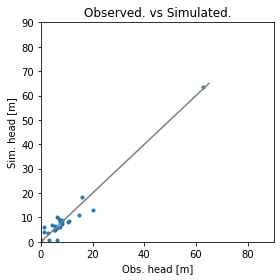

Error is - 2.6233872051605855
Params are - [8.51469650e-01 1.96291333e+01 7.09497654e+00 4.91744617e-01
 1.61882900e+00 3.93291779e-01 1.90801798e-03 1.05332795e+00
 3.46293499e-01 4.00447148e-01 6.37671162e-04 1.29869493e+00]


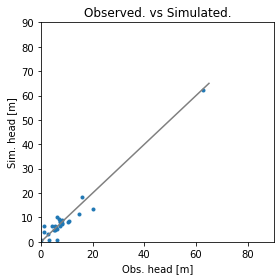

Error is - 2.6074799273594946
Params are - [8.70007229e-01 2.30758375e+01 5.36613847e+00 5.23547127e-01
 1.54359184e+00 3.92811435e-01 1.97677266e-03 1.11588138e+00
 3.53881213e-01 4.30112872e-01 4.96581234e-04 1.01429218e+00]


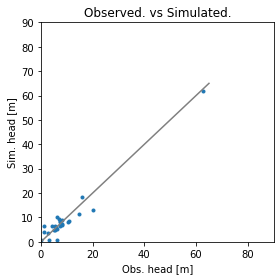

Error is - 2.61025669042824
Params are - [9.07811623e-01 2.03168130e+01 5.57686192e+00 5.51245079e-01
 1.54326698e+00 4.19884163e-01 1.99046157e-03 1.17236848e+00
 3.60248469e-01 4.40898143e-01 3.67327412e-04 1.00885656e+00]


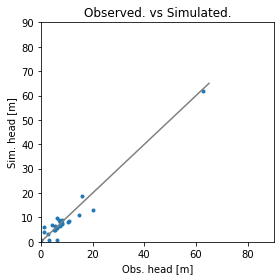

Error is - 2.615743955110686
Params are - [8.53388888e-01 2.67018673e+01 4.44061339e+00 4.88501210e-01
 1.56587482e+00 3.49142902e-01 1.99571335e-03 1.09786783e+00
 3.57779440e-01 4.30414111e-01 4.96243735e-04 8.89486378e-01]


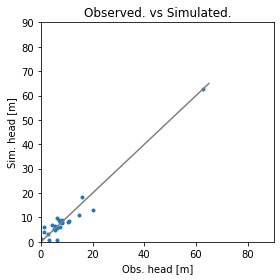

Error is - 2.6243767291132443
Params are - [8.17124517e-01 2.33280378e+01 5.35037046e+00 4.58048447e-01
 1.64267357e+00 3.38574787e-01 1.92725503e-03 1.05025412e+00
 3.58882228e-01 4.17134353e-01 6.55400702e-04 1.03425779e+00]


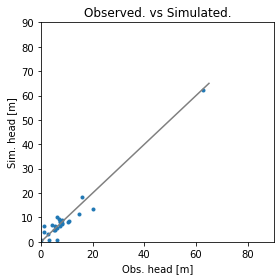

Error is - 2.616289031030827
Params are - [8.45813884e-01 2.67388224e+01 4.95594660e+00 5.11781055e-01
 1.50945874e+00 3.75594291e-01 1.98490908e-03 1.07582811e+00
 3.45675220e-01 4.23385708e-01 5.76563704e-04 9.87605021e-01]


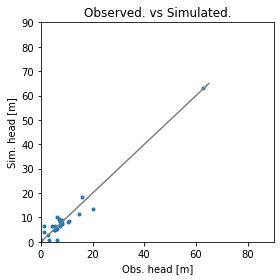

Error is - 2.61743282378733
Params are - [8.84977283e-01 2.73149865e+01 4.91425476e+00 5.50835631e-01
 1.48047987e+00 3.97437036e-01 1.95047011e-03 1.09011543e+00
 3.47262541e-01 4.36255697e-01 4.50062417e-04 9.44806804e-01]


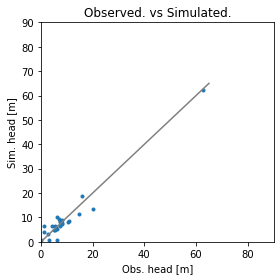

Error is - 2.612199819341917
Params are - [8.64388961e-01 2.63721031e+01 4.75455976e+00 5.23380797e-01
 1.46280550e+00 3.82397739e-01 1.99318730e-03 1.14560270e+00
 3.55529825e-01 4.25858635e-01 5.12414347e-04 9.51214687e-01]


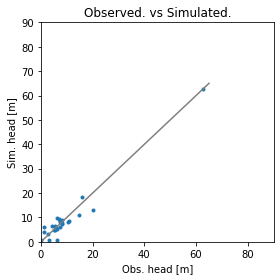

Error is - 2.6191997183371263
Params are - [8.65033292e-01 2.42286406e+01 5.17410357e+00 5.50749654e-01
 1.62168236e+00 3.87662446e-01 1.93519330e-03 1.12296653e+00
 3.49508899e-01 4.26741028e-01 5.21934051e-04 8.63496022e-01]


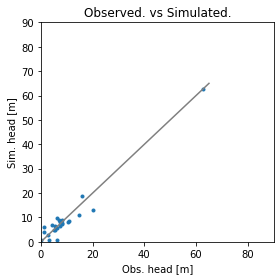

Error is - 2.615742172411637
Params are - [8.62759761e-01 2.86825211e+01 3.81294071e+00 5.28319651e-01
 1.54909723e+00 3.51402769e-01 1.94296856e-03 1.11426117e+00
 3.65900317e-01 4.39457602e-01 3.81875491e-04 6.22346896e-01]


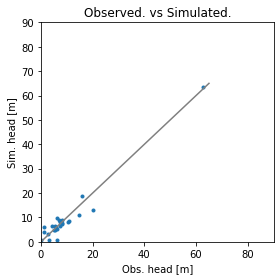

Error is - 2.6206152236543354
Params are - [8.66592387e-01 2.56451021e+01 4.67969142e+00 5.26430512e-01
 1.55932343e+00 3.76627311e-01 1.89552569e-03 1.11999186e+00
 3.62043790e-01 4.33800936e-01 4.37983155e-04 8.65184966e-01]


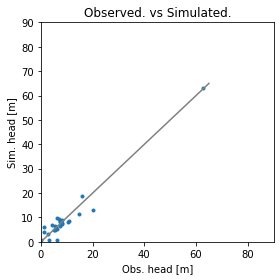

Error is - 2.6121546622550786
Params are - [8.59490523e-01 2.58822997e+01 4.76340304e+00 5.20994477e-01
 1.55196960e+00 3.73618509e-01 1.92593613e-03 1.10674110e+00
 3.57568421e-01 4.30398058e-01 4.83974817e-04 8.90777315e-01]


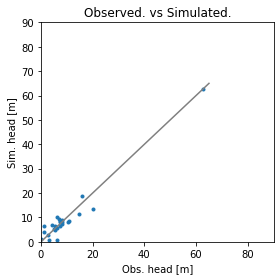

Error is - 2.617014740003493
Params are - [8.38820234e-01 2.82859637e+01 4.45167567e+00 4.75408034e-01
 1.45593041e+00 3.51216312e-01 1.97595701e-03 1.06130990e+00
 3.58020457e-01 4.27858836e-01 5.31672370e-04 9.73790186e-01]


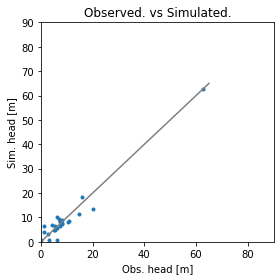

Error is - 2.616765684817662
Params are - [8.59297231e-01 2.53459487e+01 5.39384239e+00 5.35791466e-01
 1.48412899e+00 3.98350907e-01 1.96819173e-03 1.07121941e+00
 3.43789581e-01 4.17985645e-01 5.08075213e-04 1.26909722e+00]


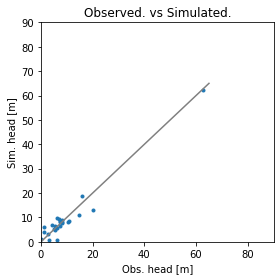

Error is - 2.614193495368556
Params are - [8.13776797e-01 2.50310603e+01 4.82284701e+00 4.70677813e-01
 1.57809061e+00 3.43120957e-01 1.96834786e-03 1.08361922e+00
 3.58870943e-01 4.14048390e-01 6.11232969e-04 1.00447084e+00]


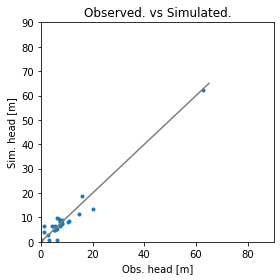

Error is - 2.608352287160289
Params are - [8.87479853e-01 2.72298367e+01 3.92364767e+00 5.27862450e-01
 1.48581080e+00 3.74886072e-01 1.97615161e-03 1.14343221e+00
 3.67454052e-01 4.39695701e-01 3.53980068e-04 8.05644481e-01]


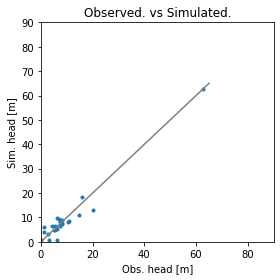

Error is - 2.6153158369666833
Params are - [8.68401293e-01 2.38718977e+01 5.05590614e+00 5.51565929e-01
 1.60838169e+00 3.90065074e-01 1.94656218e-03 1.13372848e+00
 3.52569794e-01 4.24909490e-01 4.86281583e-04 9.27582839e-01]


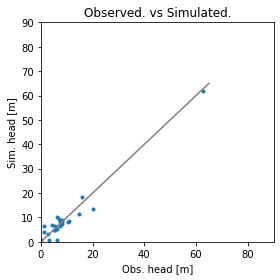

Error is - 2.6074843917760173
Params are - [8.62757525e-01 2.45522272e+01 5.10497704e+00 5.11384214e-01
 1.54240280e+00 3.59309281e-01 2.00117409e-03 1.11552330e+00
 3.53709040e-01 4.20300970e-01 5.09439941e-04 1.03393368e+00]


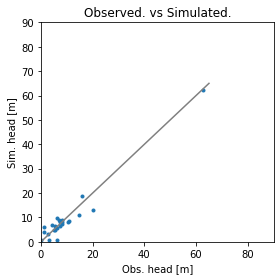

Error is - 2.62142577150644
Params are - [8.51920624e-01 2.61462348e+01 4.15892396e+00 4.92254076e-01
 1.60224861e+00 3.37579680e-01 1.96342696e-03 1.13894772e+00
 3.67837997e-01 4.34088874e-01 5.06930133e-04 6.01673803e-01]


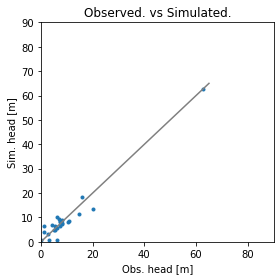

Error is - 2.610470545111261
Params are - [8.57453079e-01 2.55460202e+01 5.08511278e+00 5.24907119e-01
 1.51365890e+00 3.83158100e-01 1.96700054e-03 1.08815149e+00
 3.49801685e-01 4.22011452e-01 5.07788943e-04 1.10224137e+00]


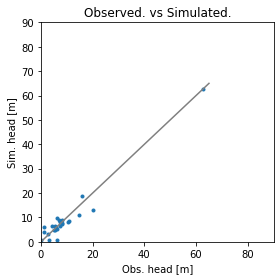

Error is - 2.6095807625154626
Params are - [8.67343837e-01 2.45545608e+01 4.61834744e+00 5.18452164e-01
 1.57761889e+00 3.61596931e-01 1.94372485e-03 1.13639292e+00
 3.66640102e-01 4.28459769e-01 4.26979182e-04 9.02272065e-01]


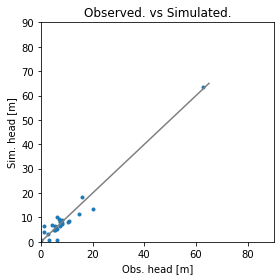

Error is - 2.6114241872283577
Params are - [8.62094658e-01 2.42336314e+01 5.16330299e+00 5.46723835e-01
 1.52316016e+00 3.90123992e-01 1.92425584e-03 1.12077405e+00
 3.56012659e-01 4.21105642e-01 4.95755059e-04 1.00252166e+00]


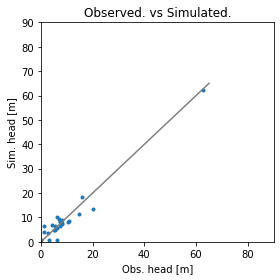

Error is - 2.6125759569759506
Params are - [8.52612934e-01 2.15114960e+01 6.01603605e+00 5.09972758e-01
 1.53561489e+00 3.94317661e-01 1.97388184e-03 1.10546619e+00
 3.46243839e-01 4.09003491e-01 6.29103230e-04 1.33302360e+00]


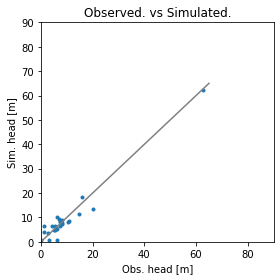

Error is - 2.60446714492629
Params are - [8.78520551e-01 2.12897523e+01 5.88773303e+00 5.19552498e-01
 1.54293782e+00 4.08527949e-01 1.98029856e-03 1.15062832e+00
 3.56672082e-01 4.21924336e-01 4.80278671e-04 1.07688162e+00]


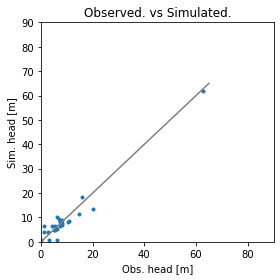

Error is - 2.6118609137739077
Params are - [8.98228983e-01 1.80105510e+01 6.71277822e+00 5.20585016e-01
 1.54395953e+00 4.40115313e-01 1.99950549e-03 1.18879531e+00
 3.57931246e-01 4.20870502e-01 4.48039182e-04 1.14361122e+00]


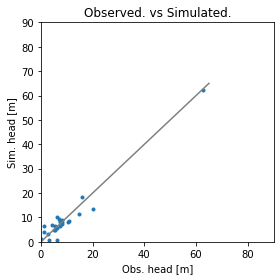

Error is - 2.609529719855196
Params are - [8.50909487e-01 2.48356521e+01 5.20810734e+00 4.80138457e-01
 1.46454321e+00 3.66893242e-01 1.98124380e-03 1.09401083e+00
 3.58939757e-01 4.20549324e-01 5.37754251e-04 1.11760432e+00]


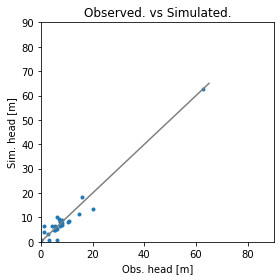

Error is - 2.60901273633836
Params are - [9.11722764e-01 2.36439214e+01 5.50537653e+00 5.62603348e-01
 1.47590973e+00 4.17799407e-01 1.96160744e-03 1.14585203e+00
 3.52650077e-01 4.32493914e-01 4.00556411e-04 1.05957190e+00]


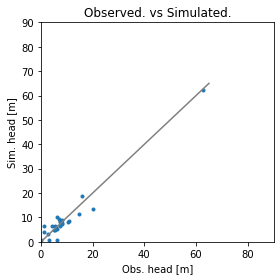

Error is - 2.609093073270419
Params are - [8.97524836e-01 2.58214165e+01 4.15481475e+00 5.52148805e-01
 1.45678309e+00 3.89692114e-01 1.99810116e-03 1.19051979e+00
 3.65843679e-01 4.40485454e-01 3.35747819e-04 8.94480363e-01]


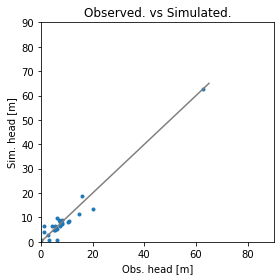

Error is - 2.606780537823799
Params are - [8.92335950e-01 2.79947138e+01 3.90655075e+00 5.41976457e-01
 1.48791716e+00 3.72484801e-01 1.96436049e-03 1.15345216e+00
 3.69539927e-01 4.46562531e-01 2.94438560e-04 6.42215673e-01]


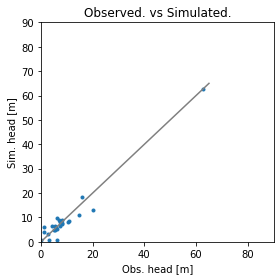

Error is - 2.607344266917408
Params are - [8.85217754e-01 2.34045418e+01 5.02669221e+00 5.31667695e-01
 1.56491183e+00 3.82752566e-01 1.94025056e-03 1.11462390e+00
 3.62588957e-01 4.33158036e-01 3.74798145e-04 9.72524748e-01]


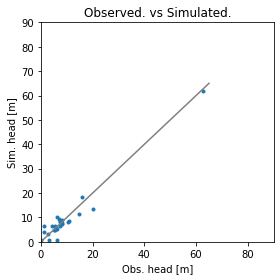

Error is - 2.6065047265341623
Params are - [8.94404064e-01 2.34813856e+01 5.06173046e+00 5.35832884e-01
 1.47790477e+00 3.93054139e-01 2.00988746e-03 1.15479930e+00
 3.61387118e-01 4.29078609e-01 3.85041563e-04 1.04658669e+00]


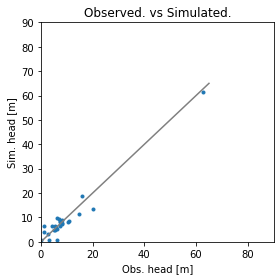

Error is - 2.610979535143847
Params are - [8.97184830e-01 2.50046796e+01 4.64490175e+00 5.08288368e-01
 1.49917165e+00 3.77037015e-01 2.02583970e-03 1.14643722e+00
 3.63838622e-01 4.39699853e-01 3.54809072e-04 9.42186525e-01]


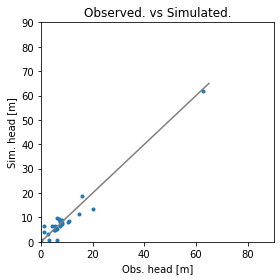

Error is - 2.6056690598203063
Params are - [8.88412287e-01 2.48119175e+01 4.77450206e+00 5.17897235e-01
 1.50516877e+00 3.80308759e-01 2.00044374e-03 1.14002143e+00
 3.61882132e-01 4.35051300e-01 3.90045569e-04 9.57270308e-01]


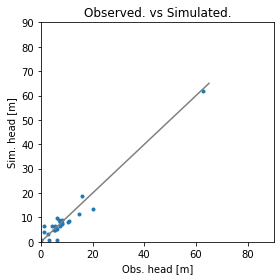

Error is - 2.600624044825332
Params are - [9.06986277e-01 2.35699403e+01 4.67132351e+00 5.28936770e-01
 1.50725789e+00 3.83528016e-01 1.98866887e-03 1.18770477e+00
 3.72063005e-01 4.40967351e-01 3.23151293e-04 8.18304968e-01]


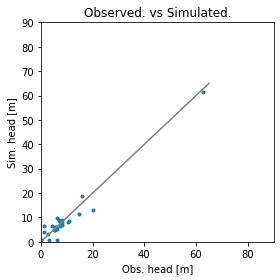

Error is - 2.604107665998146
Params are - [9.31752876e-01 2.25819003e+01 4.46442888e+00 5.30951596e-01
 1.50405738e+00 3.83712973e-01 1.99950303e-03 1.23748141e+00
 3.83193664e-01 4.50445300e-01 2.30832468e-04 6.76336767e-01]


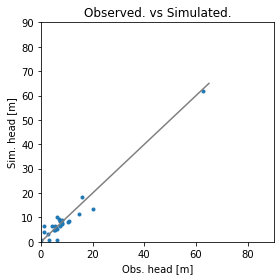

Error is - 2.615010137801412
Params are - [9.03702593e-01 2.43972963e+01 5.14691819e+00 5.37139159e-01
 1.43157106e+00 4.08744366e-01 2.01943522e-03 1.14801532e+00
 3.56128404e-01 4.36603631e-01 3.86656405e-04 1.00427976e+00]


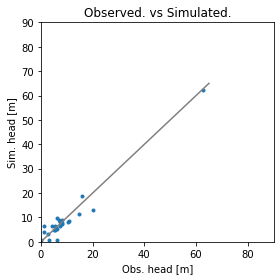

Error is - 2.6031401560473486
Params are - [8.76433526e-01 2.45152447e+01 4.75049013e+00 5.23123913e-01
 1.54110693e+00 3.73383790e-01 1.96265244e-03 1.13929852e+00
 3.64012178e-01 4.30495734e-01 4.16898488e-04 9.27773988e-01]


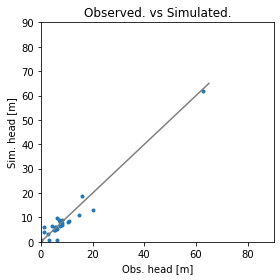

Error is - 2.610689056311355
Params are - [9.24390949e-01 2.40628038e+01 4.48088876e+00 5.82617108e-01
 1.55740736e+00 4.04529813e-01 1.97881771e-03 1.19794536e+00
 3.64674153e-01 4.46171811e-01 2.55738710e-04 7.57309116e-01]


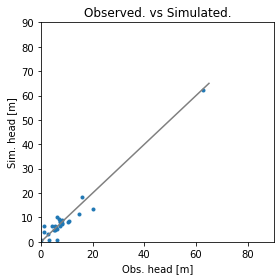

Error is - 2.6054407899998564
Params are - [8.69279852e-01 2.46424400e+01 5.02630270e+00 5.05758120e-01
 1.48775925e+00 3.76302385e-01 1.98063728e-03 1.11999446e+00
 3.60373356e-01 4.26954946e-01 4.67250366e-04 1.02753052e+00]


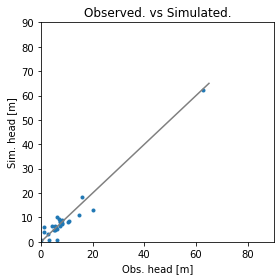

Error is - 2.605927206595522
Params are - [8.73068102e-01 2.28805433e+01 5.67942935e+00 5.02874980e-01
 1.57033018e+00 3.79499319e-01 1.95904971e-03 1.08968217e+00
 3.56858511e-01 4.23980596e-01 4.79662232e-04 1.00260810e+00]


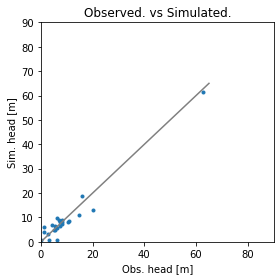

Error is - 2.61612658707789
Params are - [8.52427731e-01 2.49308087e+01 4.35787637e+00 4.82465710e-01
 1.56694028e+00 3.45008678e-01 1.99511714e-03 1.12498829e+00
 3.70753518e-01 4.30553250e-01 4.28037944e-04 8.28022593e-01]


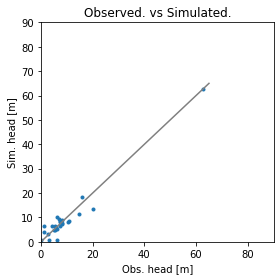

Error is - 2.604367020965388
Params are - [8.96899006e-01 2.39656432e+01 5.21850149e+00 5.42568938e-01
 1.49866737e+00 3.99601725e-01 1.96998487e-03 1.14063609e+00
 3.57175937e-01 4.32008748e-01 4.07426794e-04 1.00168457e+00]


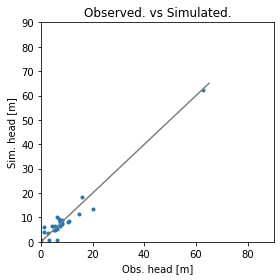

Error is - 2.6055530874856268
Params are - [8.78240501e-01 2.08008612e+01 6.15541420e+00 5.19657689e-01
 1.55918197e+00 3.92041289e-01 1.97954517e-03 1.12694209e+00
 3.54236524e-01 4.22070304e-01 4.83522075e-04 1.11462336e+00]


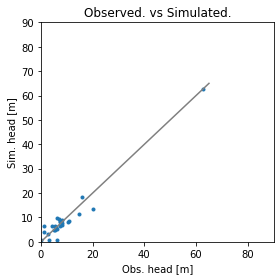

Error is - 2.6016949297685894
Params are - [9.05543325e-01 2.28532430e+01 5.14915769e+00 5.37514837e-01
 1.50538650e+00 4.13073414e-01 1.95091788e-03 1.15675413e+00
 3.68069450e-01 4.41759923e-01 3.23742558e-04 8.99782441e-01]


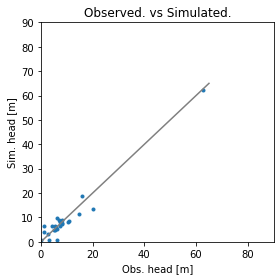

Error is - 2.596443163006715
Params are - [9.04216303e-01 2.42925336e+01 4.85183279e+00 5.27679876e-01
 1.49782990e+00 3.82948257e-01 1.97101018e-03 1.16320817e+00
 3.70261983e-01 4.33889197e-01 3.07794818e-04 9.00338984e-01]


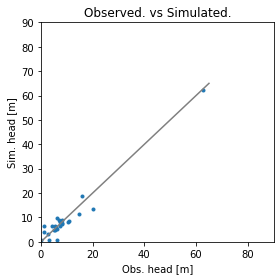

Error is - 2.592405557645737
Params are - [9.21320841e-01 2.49008817e+01 4.59467995e+00 5.29746250e-01
 1.47494893e+00 3.78016668e-01 1.96812894e-03 1.18687157e+00
 3.78452368e-01 4.35777359e-01 2.13401611e-04 8.43362385e-01]


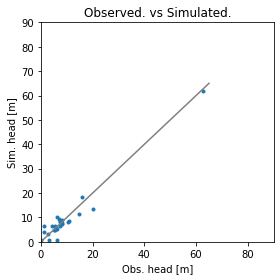

Error is - 2.6059024898022463
Params are - [8.95022959e-01 2.42132193e+01 5.11927701e+00 5.19239067e-01
 1.46151609e+00 3.92217810e-01 2.01217868e-03 1.17650694e+00
 3.64198141e-01 4.31280587e-01 4.02678484e-04 9.20579355e-01]


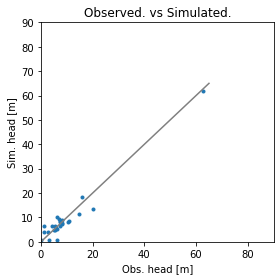

Error is - 2.608538165309799
Params are - [8.88352598e-01 1.89927982e+01 6.44153951e+00 5.05140739e-01
 1.53411058e+00 4.05774410e-01 1.99603844e-03 1.14152114e+00
 3.56356873e-01 4.15329102e-01 5.01078057e-04 1.29728238e+00]


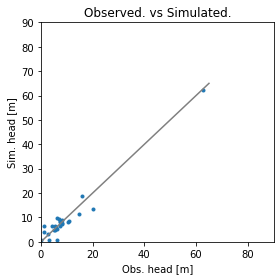

Error is - 2.602245263536474
Params are - [8.91340112e-01 2.57442349e+01 4.54029794e+00 5.32767528e-01
 1.49946552e+00 3.80807203e-01 1.97227998e-03 1.15046940e+00
 3.66244163e-01 4.38754173e-01 3.46098434e-04 8.05982349e-01]


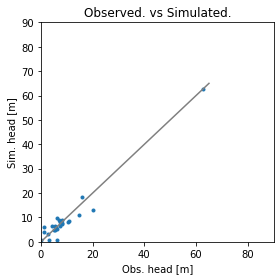

Error is - 2.603444822949408
Params are - [8.85773826e-01 2.38832680e+01 5.19945438e+00 5.10773420e-01
 1.54771643e+00 3.83163915e-01 1.94424355e-03 1.13945235e+00
 3.65319190e-01 4.34425617e-01 4.03984532e-04 8.52810632e-01]


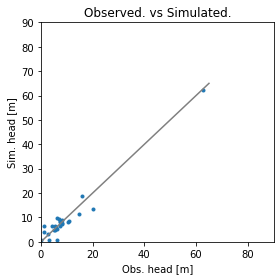

Error is - 2.6032484790734944
Params are - [9.09227408e-01 2.46512311e+01 4.50175967e+00 5.45047731e-01
 1.45152207e+00 3.97329501e-01 1.99261362e-03 1.21286450e+00
 3.71257910e-01 4.41264467e-01 2.96750914e-04 8.71822986e-01]


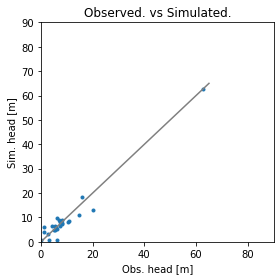

Error is - 2.606854453846729
Params are - [8.89639959e-01 2.33915570e+01 4.95899245e+00 5.32985088e-01
 1.55867049e+00 3.85462960e-01 1.93622381e-03 1.13209933e+00
 3.65094908e-01 4.35628456e-01 3.56080066e-04 9.45725666e-01]


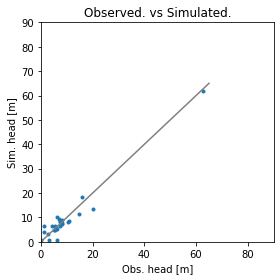

Error is - 2.6024884336004397
Params are - [8.93677209e-01 2.40078037e+01 5.07920587e+00 5.22675572e-01
 1.48580469e+00 3.90529097e-01 1.99318996e-03 1.16540504e+00
 3.64422333e-01 4.32367554e-01 3.91028880e-04 9.26865932e-01]


In [ ]:
# run optimization 

"""             {-12:Alluvium_Aua, 
               -14:Alluvium_Fagaalu, 
               -15:Alluvium_minor,
               -13:Alluvium_Utulei,
               -11:Alluvium_Vaipito,
               -10:Alluvium_Vatia,
               -50:Dikes,
               -30:Pago_inner_E,
               -40:Pago_inner_W,
               -20:Pago_outer,
               -60:Trachyte,     
               -16:Alluvium_Laulii}}   """

# Start
# params = [4.6, 13.0, 0.1, 5.0, 2.6, 0.4, 0.3, 0.1, 0.5, 0.6, 0.3]
# Better
# params = [2.1, 28.6, 0.05, 7.2, 1.8, 0.7, 0.01, 0.15, 0.4, 1.5, 0.01]
# Better
# params = [2.6, 39, 1, 14, 3.7, 1.2, 0.001, 0.37, 0.9, 0.7, 0.003, 1]
#[0.7, 32, 6.8, 1.9, 1.5, 5.0, 0.001, 1.0, 0.25, 0.2, 0.0015, 2.5] 


params = [0.7, 16, 16,  0.5, 1.0, 0.5, 0.0023, 0.7, 0.17, 0.3, 0.0017, 3.75] 



# The main optimization function
results = opt.minimize(calibrateo, x0= params, method="Nelder-Mead",tol = 0.1)

In [ ]:
best_so_far = [0.93, 22.5, 4.5, 0.5, 1.5, 0.38, 0.002, 1.2, 0.38, 0.45, 0.00023, 0.68] ~2.6 errort
 


# With the rcp4.5 recharge , nOOOO   [1.3, 27, 11.5, 0.3, 1.2, 0.27, 0.00158, 0.73, 0.42, 0.38, 0.000003, 1.6] 



In [ ]:
# Currently not used modual to Read cell-by-cell flow budget and extract out drain flows

cbf = flopy.utils.CellBudgetFile(os.path.join(workspace, modelname+'.cbc'))
ts_stressF = cbf.get_kstpkper()  # Return a list of unique stress periods & ts
kstpkperF = ts_stressF[-1]       # get the last kstp, kper combination
drf = cbf.get_data(kstpkper=kstpkperF, text='DRAINS')[0]

drf_frame = pd.DataFrame(drf)

drnElv_lst_qs = drnElv_lst.copy()
drnElv_lst_qs['node'] = drf_frame['node']
drnElv_lst_qs['q'] = drf_frame['q']

Grid = geopandas.read_file(os.path.join(workspace, 'Model_grid.shp'))
Grid_drains = Grid.merge(drnElv_lst_qs, on='node', how="left")

Grid_drains.to_file(driver = 'ESRI Shapefile', filename = os.path.join(tempspace, 'Drain_flow_grid.shp'))          # write a shapefile of the model grid for later use
prj = open(os.path.join(tempspace, 'Drain_flow_grid.prj'), "w"); prj.write(WGS84UTM2S_string) ; prj.close()   # write the .prj file manually